# Thêm thư viện cần thiết

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, classification_report

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

import numpy as np
import joblib
import torch
import random
import os
import unidecode
import re
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="keras")



# Load dữ liệu

In [550]:
df = pd.read_excel('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời).xlsx', header = 0)
df.head(10)

Dấu thời gian                   Địa chỉ email  \
0 2023-05-23 15:30:25.450              yen68047@gmail.com   
1 2023-05-23 15:39:15.998   buithikhanhthanhthi@gmail.com   
2 2023-05-23 15:42:05.199              hlamdieu@gmail.com   
3 2023-05-23 15:42:07.155            rinriny397@gmail.com   
4 2023-05-23 15:43:32.298  luongkhanhlinh220406@gmail.com   
5 2023-05-23 15:44:13.667             vutthcstt@gmail.com   
6 2023-05-23 15:45:42.900      thaonguyenperson@gmail.com   
7 2023-05-23 15:46:21.425          huytoyhotboy@gmail.com   
8 2023-05-23 15:48:11.547        buithinga.2k7@iclaud.com   
9 2023-05-23 15:48:24.670        hoanganphuc127@gmail.com   

  Bạn đang ở tỉnh nào?  1. Giới tính 2. Khối lớp  \
0             Hoà Bình            Nữ     Khối 11   
1             Hoà Bình            Nữ     Khối 10   
2               Sơn La            Nữ     Khối 11   
3             Hoà Bình            Nữ     Khối 10   
4               Sơn La            Nữ     Khối 11   
5               Sơn La           Nam     Khối 11   
6               Sơn La            Nữ     Khối 11   
7               Sơn La           Nam     Khối 12   
8             Hoà Bình            Nữ     Khối 10   
9               Sơn La           Nam     Khối 11   

  3. Trường THPT bạn đang học? (Ví dụ: Chuyên Khoa học tự nhiên,...)  \
0                                           Tự nhiên                   
1                                      THPT Sào Báy                    
2                  TH-THCS & THPT Chu Văn An, Sơn La                   
3                                      Thpt Sào Báy                    
4                            TH-THCS-THPT Chu Văn An                   
5                                         Chu Văn An                   
6                                 THPT Chuyên Sơn La                   
7                                         Chu Văn An                   
8                                Trường THPT Sào Báy                   
9                                      Chuyên Sơn La                   

  4. Số báo danh thi THPT(Nếu có, Đối với khối 12)  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   
5                                              NaN   
6                                              NaN   
7                                              NaN   
8                                              NaN   
9                                              NaN   

  5. Bạn là người dân tộc gì (Ví dụ: Kinh, Mông,...)  \
0                                              Mường   
1                                              Mường   
2                                               Thái   
3                                              Mường   
4                                               Kinh   
5                                               Thái   
6                                               Kinh   
7                                               Kinh   
8                                              Mường   
9                                               Kinh   

  6.  Khoảng cách từ nhà/ nơi ở của em đến trường là bao nhiêu?  \
0                                         Trên 10 Km              
1                                         Trên 10 Km              
2                                      Từ 3 Km -5 Km              
3                                         Trên 10 Km              
4                                     Từ 5 Km -10 Km              
5                                         Trên 10 Km              
6                                         Trên 10 Km              
7                                          Dưới 3 Km              
8                                          Dưới 3 Km              
9                                     Từ 5 Km -10 Km              

  7.  Nơi ở khi tham gia

# Làm sạch dữ liệu

* loại bỏ những dòng dữ liệu thiếu trên 50% giá trị

In [551]:
def remove_rows_with_high_nan(df, threshold=0.5):
    # Thay thế các giá trị 'None' và 'nan' bằng np.nan
    df.replace(['None', 'nan', 'NaN', ' ', ''], np.nan, inplace=True)
    
    # Tính tỷ lệ NaN trên mỗi hàng
    nan_ratio = df.isna().mean(axis=1)
    
    # Lọc các hàng có tỷ lệ NaN lớn hơn hoặc bằng ngưỡng
    filtered_df = df[nan_ratio < threshold]
    
    # Đếm số lượng các hàng bị loại bỏ (tức là có tỷ lệ NaN >= threshold)
    count_high_nan_rows = (nan_ratio >= threshold).sum()
    
    return filtered_df, count_high_nan_rows

In [552]:
df_cleaned, num_removed = remove_rows_with_high_nan(df, threshold=0.5)
print(f"Số lượng dòng bị loại bỏ: {num_removed}")

Số lượng dòng bị loại bỏ: 0


* Loại bỏ những dòng giá trị lặp của cột email

In [553]:
initial_count = df.shape[0]

# Loại bỏ các dòng trùng lặp dựa trên cột 'Địa chỉ email'
df_unique = df.drop_duplicates(subset='Địa chỉ email', keep='first')

# Tính số lượng dòng sau khi loại bỏ
final_count = df_unique.shape[0]

# Tính số lượng dòng đã loại bỏ
removed_count = initial_count - final_count

# In kết quả
print(f"Số lượng dòng đã loại bỏ: {removed_count}")

Số lượng dòng đã loại bỏ: 10


* Loại bỏ những cột không cần thiết

In [554]:
df = df.drop(columns=['Dấu thời gian', 'Địa chỉ email', '4. Số báo danh thi THPT(Nếu có, Đối với khối 12)', '3. Trường THPT bạn đang học? (Ví dụ: Chuyên Khoa học tự nhiên,...)'], errors='ignore')

In [555]:
# Lọc những cột có giá trị thiếu
columns_with_na = df.columns[df.isnull().any()].tolist()

# In ra danh sách các cột có giá trị thiếu
print("Các cột có giá trị thiếu:", columns_with_na)

Các cột có giá trị thiếu: ['17. Nếu học thêm, mỗi tuần em học thêm bao nhiêu lâu?................ (Ví dụ: 3h, 3 tiếng)', '18. Nếu em đi học thêm, mỗi tháng mất bao nhiêu tiên cho việc học thêm môn toán?................ đồng  (Ví dụ: 1000000 hoặc 1 triệu)', '2.3.  Yếu tố nào có ảnh hưởng đến kết quả học môn Toán của Em (liệt kê từ 1 đến 3 yếu tố)?']


## Hiển thị thông tin dataFrame

In [556]:
def show_infor_dataframe(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"Column '{column}' has {len(unique_values)} unique values:")
        print(unique_values)
        print("\n")

In [557]:
show_infor_dataframe(df)

Column 'Bạn đang ở tỉnh nào?' has 4 unique values:
['Hoà Bình' 'Sơn La' 'Lai Châu' 'Điện Biên']


Column ' 1. Giới tính' has 2 unique values:
['Nữ' 'Nam']


Column '2. Khối lớp' has 3 unique values:
['Khối 11' 'Khối 10' 'Khối 12']


Column '5. Bạn là người dân tộc gì (Ví dụ: Kinh, Mông,...)' has 5 unique values:
['Mường' 'Thái' 'Kinh' 'Khác' 'Mông']


Column '6.  Khoảng cách từ nhà/ nơi ở của em đến trường là bao nhiêu?' has 4 unique values:
['Trên 10 Km' 'Từ 3 Km -5 Km' 'Từ 5 Km -10 Km' 'Dưới 3 Km']


Column '7.  Nơi ở khi tham gia học hiện nay của em là?' has 3 unique values:
['Ở với gia đình' 'Ở ký túc xá của Nhà trường' 'Trọ ngoài']


Column '8. Những phương tiện nào sau đây có trong gia đình em? [Bàn học riêng]' has 2 unique values:
['Không' 'Có']


Column '8. Những phương tiện nào sau đây có trong gia đình em? [Phòng riêng]' has 2 unique values:
['Có' 'Không']


Column '8. Những phương tiện nào sau đây có trong gia đình em? [Máy tính cá nhân (laptop)]' has 2 unique values:
['Khôn

In [558]:
def display_column_info(df):
    for column in df.columns:
        # Kiểu dữ liệu của cột
        col_type = df[column].dtype
        
        # Số lượng giá trị không bị thiếu
        non_null_count = df[column].notna().sum()
        
        # Tổng số giá trị
        total_count = len(df[column])
        
        # Tính số lượng và tỷ lệ phần trăm giá trị thiếu
        missing_count = total_count - non_null_count
        missing_percentage = (missing_count / total_count) * 100
        
        
        print(f"Column: {column}")
        print(f"  Data Type: {col_type}")
        print(f"  Non-null Count: {non_null_count}")
        print(f"  Total Count: {total_count}")
        print(f"  Missing Values Count: {missing_count}")
        print(f"  Missing Values Percentage: {missing_percentage:.2f}%")
        print()
        # Kiểm tra xem tỷ lệ giá trị thiếu có cao không
        if missing_percentage >= 50:
            print(f"  Column {column} có {missing_percentage:.2f}% giá trị bị thiếu nhiều, cần xóa")
        print()
        print()

In [559]:
display_column_info(df)

Column: Bạn đang ở tỉnh nào?
  Data Type: object
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column:  1. Giới tính
  Data Type: object
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 2. Khối lớp
  Data Type: object
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 5. Bạn là người dân tộc gì (Ví dụ: Kinh, Mông,...)
  Data Type: object
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 6.  Khoảng cách từ nhà/ nơi ở của em đến trường là bao nhiêu?
  Data Type: object
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 7.  Nơi ở khi tham gia học hiện nay của em là?
  Data Type: object
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00

In [560]:
# In danh sách tên các cột
print(df.columns.tolist())

['Bạn đang ở tỉnh nào?', ' 1. Giới tính', '2. Khối lớp', '5. Bạn là người dân tộc gì (Ví dụ: Kinh, Mông,...)', '6.  Khoảng cách từ nhà/ nơi ở của em đến trường là bao nhiêu?', '7.  Nơi ở khi tham gia học hiện nay của em là?', '8. Những phương tiện nào sau đây có trong gia đình em? [Bàn học riêng]', '8. Những phương tiện nào sau đây có trong gia đình em? [Phòng riêng]', '8. Những phương tiện nào sau đây có trong gia đình em? [Máy tính cá nhân (laptop)]', '8. Những phương tiện nào sau đây có trong gia đình em? [Mạng Internet]', '8. Những phương tiện nào sau đây có trong gia đình em? [Máy tính bỏ túi]', '8. Những phương tiện nào sau đây có trong gia đình em? [Máy tính bảng (Ipad/ Tablet)]', '8. Những phương tiện nào sau đây có trong gia đình em? [Điện thoại di động (Smartphone)]', '8. Những phương tiện nào sau đây có trong gia đình em? [Sách tham khảo toán]', '8. Những phương tiện nào sau đây có trong gia đình em? [Tài khoản học online môn toán]', '9. Hiện nay em đang sống với ai?', '10. 

## Đổi tên các cột dữ liệu

In [561]:
# Đổi tên cột
def rename_columns(original_columns):
    new_columns = []
    rename_dict = {}
    column_count = {}  
    
    for col in original_columns:
        cleaned_name = unidecode.unidecode(col.strip())
        cleaned_name = ''.join(e if e.isalnum() or e in ['_'] else '_' for e in cleaned_name)
        short_name = cleaned_name[:30]  
    
        if short_name in column_count:
            column_count[short_name] += 1
            short_name = f"{short_name}_{column_count[short_name]}" 
        else:
            column_count[short_name] = 1
        
        new_columns.append(short_name)
        rename_dict[col] = short_name

    return new_columns, rename_dict

In [ ]:
# Gọi hàm để đổi tên cột
new_column_names, rename_mapping = rename_columns(df.columns.tolist())

# Đặt tên cột mới cho DataFrame
df.columns = new_column_names

# Lưu lại mapping vào file
rename_df = pd.DataFrame(list(rename_mapping.items()), columns=['Tên cũ', 'Tên mới'])
rename_df.to_csv('model/rename_mapping.csv', index=False)

In [563]:
# In danh sách tên các cột
print(df.columns.tolist())

['Ban_dang_o_tinh_nao_', '1__Gioi_tinh', '2__Khoi_lop', '5__Ban_la_nguoi_dan_toc_gi__Vi', '6___Khoang_cach_tu_nha__noi_o_', '7___Noi_o_khi_tham_gia_hoc_hie', '8__Nhung_phuong_tien_nao_sau_d', '8__Nhung_phuong_tien_nao_sau_d_2', '8__Nhung_phuong_tien_nao_sau_d_3', '8__Nhung_phuong_tien_nao_sau_d_4', '8__Nhung_phuong_tien_nao_sau_d_5', '8__Nhung_phuong_tien_nao_sau_d_6', '8__Nhung_phuong_tien_nao_sau_d_7', '8__Nhung_phuong_tien_nao_sau_d_8', '8__Nhung_phuong_tien_nao_sau_d_9', '9__Hien_nay_em_dang_song_voi_a', '10__Trinh_do_hoc_van_cao_nhat_', '11__Trinh_do_hoc_van_cao_nhat_', '12__Nghe_nghiep_cua_ME_em_la', '13__Nghe_nghiep_cua_BO_em_la', '14__Thu_nhap_trung_binh_moi_th', '15__Muc_do_thuong_xuyen_em_giu', '16__Hien_nay_em_di_hoc_them_be', '17__Neu_hoc_them__moi_tuan_em_', '18__Neu_em_di_hoc_them__moi_th', '19__Diem_mon_toan_bai_kiem_tra', '20__Diem_tong_ket_mon_toan_hoc', '21__Em_co_tham_gia_cau_lac_bo_', '22__Hay_cho_biet_muc_do_thuong', '23__O_nha_em_co_bao_nhieu_cuon', 'I__GIA_DINH__

## Hàm thống kê tuần suất xuất hiện

In [564]:
def calculate_percentage(df, column_name):
    # Tính số lượng xuất hiện của mỗi giá trị
    value_counts = df[column_name].value_counts(dropna=False)
    
    # Tính tỷ lệ phần trăm
    percentages = (value_counts / len(df)) * 100
    
    # Tạo DataFrame kết quả
    result = pd.DataFrame({'Value': value_counts.index, 'Percentage': percentages.values})
    
    return result

In [565]:
def calculate_percentage_for_columns(df, columns):
    # Khởi tạo dictionary để lưu kết quả của từng cột
    result_dict = {}
    
    # Duyệt qua từng cột trong danh sách và tính tỷ lệ phần trăm
    for column in columns:
        try:
            result_dict[column] = calculate_percentage(df, column)
        except KeyError:
            print(f"Cột '{column}' không tồn tại trong DataFrame")
    
    # In kết quả
    for column, result_df in result_dict.items():
        print(f"Tỷ lệ phần trăm xuất hiện trong cột '{column}':")
        print(result_df)
        print("\n")  # Thêm khoảng trắng giữa các kết quả cho dễ đọc
    
    # Trả về dictionary chứa các kết quả
    return result_dict

In [566]:
def plot_value_counts(df, column_name):
    # Tính tần suất xuất hiện của các giá trị
    value_counts = df[column_name].value_counts()
    
    # Thiết lập kích thước biểu đồ
    plt.figure(figsize=(4, 3))
    
    # Vẽ biểu đồ tần suất với seaborn
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
    
    # Đặt tiêu đề và nhãn trục
    plt.title(f'Tần suất xuất hiện của các giá trị trong cột {column_name}')
    plt.xlabel('Giá trị')
    plt.ylabel('Tần suất')
    plt.xticks(rotation=45)
    
    # Hiển thị biểu đồ
    plt.show()

In [567]:
columns_to_calculate_percentage = ['Ban_dang_o_tinh_nao_', '1__Gioi_tinh', '2__Khoi_lop', '5__Ban_la_nguoi_dan_toc_gi__Vi', 
                                   '6___Khoang_cach_tu_nha__noi_o_', '7___Noi_o_khi_tham_gia_hoc_hie', '8__Nhung_phuong_tien_nao_sau_d', 
                                   '8__Nhung_phuong_tien_nao_sau_d_2', '8__Nhung_phuong_tien_nao_sau_d_3', '8__Nhung_phuong_tien_nao_sau_d_4', 
                                   '8__Nhung_phuong_tien_nao_sau_d_5', '8__Nhung_phuong_tien_nao_sau_d_6', '8__Nhung_phuong_tien_nao_sau_d_7', 
                                   '8__Nhung_phuong_tien_nao_sau_d_8', '8__Nhung_phuong_tien_nao_sau_d_9', '9__Hien_nay_em_dang_song_voi_a', 
                                   '10__Trinh_do_hoc_van_cao_nhat_', '11__Trinh_do_hoc_van_cao_nhat_', '12__Nghe_nghiep_cua_ME_em_la', 
                                   '13__Nghe_nghiep_cua_BO_em_la', '14__Thu_nhap_trung_binh_moi_th', '15__Muc_do_thuong_xuyen_em_giu', 
                                   '16__Hien_nay_em_di_hoc_them_be',   '21__Em_co_tham_gia_cau_lac_bo_', '22__Hay_cho_biet_muc_do_thuong', 
                                   '23__O_nha_em_co_bao_nhieu_cuon', 'I__GIA_DINH__Bo_me_toi_rat_luo', 'I__GIA_DINH__Bo_me_luon_hoi_to', 
                                   'I__GIA_DINH__Bo__me_muon_toi_t', 'I__GIA_DINH__Bo_me_quan_tam_to', 'I__GIA_DINH__Bo_me_kem_toi_hoa', 
                                   'I__GIA_DINH__Bo_me_trao_doi_vo', 'I__GIA_DINH__Bo_me_tim_cho_hoc', 'I__GIA_DINH__Bo_me_la_mang_toi', 
                                   'I__GIA_DINH__Bo_me_khen_thuong', 'I__GIA_DINH__Em_co_trao_doi_vo', 'II___DONG_CO__TU_TIN__QUAN_DIE', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_2', 'II___DONG_CO__TU_TIN__QUAN_DIE_3', 'II___DONG_CO__TU_TIN__QUAN_DIE_4', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_5', 'II___DONG_CO__TU_TIN__QUAN_DIE_6', 'II___DONG_CO__TU_TIN__QUAN_DIE_7', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_8', 'II___DONG_CO__TU_TIN__QUAN_DIE_9', 'II___DONG_CO__TU_TIN__QUAN_DIE_10', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_11', 'II___DONG_CO__TU_TIN__QUAN_DIE_12', 'II___DONG_CO__TU_TIN__QUAN_DIE_13', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_14', 'II___DONG_CO__TU_TIN__QUAN_DIE_15', 'II___DONG_CO__TU_TIN__QUAN_DIE_16', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_17', 'II___DONG_CO__TU_TIN__QUAN_DIE_18', 'II___DONG_CO__TU_TIN__QUAN_DIE_19', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_20', 'II___DONG_CO__TU_TIN__QUAN_DIE_21', 'II___DONG_CO__TU_TIN__QUAN_DIE_22', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_23', 'II___DONG_CO__TU_TIN__QUAN_DIE_24', 'II___DONG_CO__TU_TIN__QUAN_DIE_25', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_26', 'II___DONG_CO__TU_TIN__QUAN_DIE_27', 'II___DONG_CO__TU_TIN__QUAN_DIE_28', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_29', 'II___DONG_CO__TU_TIN__QUAN_DIE_30', 'II___DONG_CO__TU_TIN__QUAN_DIE_31', 
                                   'III___PHONG_CACH_HOC_TAP__Em_c', 'III___PHONG_CACH_HOC_TAP__Em_t', 'III___PHONG_CACH_HOC_TAP__Em_t_2', 
                                   'III___PHONG_CACH_HOC_TAP__Em_t_3', 'III___PHONG_CACH_HOC_TAP__Em_t_4', 'III___PHONG_CACH_HOC_TAP__Em_t_5', 
                                   'III___PHONG_CACH_HOC_TAP__Em_t_6', 'IV__GIAO_VIEN_TOAN__Giao_vien_', 'IV__GIAO_VIEN_TOAN__Giao_vien__2', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__3', 'IV__GIAO_VIEN_TOAN__Giao_vien__4', 'IV__GIAO_VIEN_TOAN__Giao_vien__5', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__6', 'IV__GIAO_VIEN_TOAN__Giao_vien__7', 'IV__GIAO_VIEN_TOAN__Giao_vien__8', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__9', 'IV__GIAO_VIEN_TOAN__Giao_vien__10', 'IV__GIAO_VIEN_TOAN__Giao_vien__11', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__12', 'V__MOI_TRUONG_HOC_TAP__Em_co_c', 'V__MOI_TRUONG_HOC_TAP__Cac_ban', 
                                   'V__MOI_TRUONG_HOC_TAP__Giao_vi', 'V__MOI_TRUONG_HOC_TAP__Y_kien_', 'V__MOI_TRUONG_HOC_TAP__Em_duoc', 
                                   'V__MOI_TRUONG_HOC_TAP__Em_hoc_', 'V__MOI_TRUONG_HOC_TAP__Em_va_c', 'V__MOI_TRUONG_HOC_TAP__Cac_ban_2', 
                                   'V__MOI_TRUONG_HOC_TAP__Khi_lam', 'V__MOI_TRUONG_HOC_TAP__Em_nhan', 'V__MOI_TRUONG_HOC_TAP__Em_duoc_2', 
                                   'V__MOI_TRUONG_HOC_TAP__Em_co_c_2', 'V__MOI_TRUONG_HOC_TAP__Cac_gia', 'V__MOI_TRUONG_HOC_TAP__Em_duoc_3', 
                                   'V__MOI_TRUONG_HOC_TAP__Giao_vi_2', 'V__MOI_TRUONG_HOC_TAP__Em_luon', 'V__MOI_TRUONG_HOC_TAP__Truong_', 
                                   'V__MOI_TRUONG_HOC_TAP__Boi_vi_', 'V__MOI_TRUONG_HOC_TAP__Nhung_t', 'V__MOI_TRUONG_HOC_TAP__Ban_ghe', 
                                   'VI__CONG_NGHE__Giao_vien_Toan_', 'VI__CONG_NGHE__Giao_vien_Toan__2', 'VI__CONG_NGHE__Giao_vien_Toan__3', 
                                   'VI__CONG_NGHE__Em_thuong_dung_', 'VI__CONG_NGHE__Em_tu_hoc_toan_', 'VI__CONG_NGHE__Nha_truong_co_d', 
                                   'VI__CONG_NGHE__Em_duoc_phep_su', 'VI__CONG_NGHE__Giao_vien_Toan__4']

In [568]:
# # Khởi tạo dictionary để lưu kết quả của từng cột
# result_dict = {}

# # Duyệt qua từng cột trong danh sách và tính tỷ lệ phần trăm
# for column in columns_to_calculate_percentage:
#     try:
#         result_dict[column] = plot_value_counts(df, column)
#     except KeyError:
#         print(f"Cột '{column}' không tồn tại trong DataFrame")

In [569]:
# Khởi tạo dictionary để lưu kết quả của từng cột
result_dict = {}

# Duyệt qua từng cột trong danh sách và tính tỷ lệ phần trăm
for column in columns_to_calculate_percentage:
    try:
        result_dict[column] = calculate_percentage(df, column)
    except KeyError:
        print(f"Cột '{column}' không tồn tại trong DataFrame")

# In kết quả
for column, result_df in result_dict.items():
    print(f"Tỷ lệ phần trăm xuất hiện trong cột '{column}':")
    print(result_df)
    print("\n")  # Thêm khoảng trắng giữa các kết quả cho dễ đọc

Tỷ lệ phần trăm xuất hiện trong cột 'Ban_dang_o_tinh_nao_':
       Value  Percentage
0   Lai Châu   36.995153
1     Sơn La   33.279483
2   Hoà Bình   16.155089
3  Điện Biên   13.570275


Tỷ lệ phần trăm xuất hiện trong cột '1__Gioi_tinh':
  Value  Percentage
0    Nữ    58.15832
1   Nam    41.84168


Tỷ lệ phần trăm xuất hiện trong cột '2__Khoi_lop':
     Value  Percentage
0  Khối 12   41.195477
1  Khối 11   41.033926
2  Khối 10   17.770598


Tỷ lệ phần trăm xuất hiện trong cột '5__Ban_la_nguoi_dan_toc_gi__Vi':
   Value  Percentage
0   Kinh   42.810985
1   Thái   32.148627
2  Mường   16.316640
3   Khác    5.008078
4   Mông    3.715670


Tỷ lệ phần trăm xuất hiện trong cột '6___Khoang_cach_tu_nha__noi_o_':
            Value  Percentage
0       Dưới 3 Km   28.756058
1      Trên 10 Km   26.332795
2  Từ 5 Km -10 Km   25.525040
3   Từ 3 Km -5 Km   19.386107


Tỷ lệ phần trăm xuất hiện trong cột '7___Noi_o_khi_tham_gia_hoc_hie':
                        Value  Percentage
0              Ở với g

In [570]:
df = df.drop(columns=['8__Nhung_phuong_tien_nao_sau_d', '8__Nhung_phuong_tien_nao_sau_d_4','8__Nhung_phuong_tien_nao_sau_d_6', 
                      '8__Nhung_phuong_tien_nao_sau_d_5', '8__Nhung_phuong_tien_nao_sau_d_7', '9__Hien_nay_em_dang_song_voi_a', 
                      '21__Em_co_tham_gia_cau_lac_bo_', '22__Hay_cho_biet_muc_do_thuong'], errors='ignore')

In [571]:
df['5__Ban_la_nguoi_dan_toc_gi__Vi'] = df['5__Ban_la_nguoi_dan_toc_gi__Vi'].map({'Kinh': 0, 'Thái': 1, 'Khác': 2, 'Mông': 2, 'Mường': 2})
df['7___Noi_o_khi_tham_gia_hoc_hie'] = df['7___Noi_o_khi_tham_gia_hoc_hie'].map({'Ở với gia đình': 0, 'Ở ký túc xá của Nhà trường': 1, 'Trọ ngoài': 1})
df['23__O_nha_em_co_bao_nhieu_cuon'] = df['23__O_nha_em_co_bao_nhieu_cuon'].map({'Từ 0 đến 10 cuốn': 0, 'Từ 11 đến 25 cuốn': 1, 
                                                                                 'Từ 26 đến 100 cuốn': 1, 'Từ 101 đến 200 cuốn': 1,
                                                                                 'Từ 200 cuốn trở lên': 1})
df['15__Muc_do_thuong_xuyen_em_giu'] = df['15__Muc_do_thuong_xuyen_em_giu'].map({'Thường xuyên': 0, 'Thỉnh thoảng': 1, 'Không bao giờ': 1})

In [572]:
def standardize(value):
    if value in ["Đồng ý", "Hoàn toàn đồng ý"]:
        return 0
    elif value in ["Không đồng ý", "Hoàn toàn không đồng ý"]:
        return 1
    else:
        return 2

In [573]:
columns_to_standardize = ['I__GIA_DINH__Bo_me_toi_rat_luo', 'I__GIA_DINH__Bo_me_luon_hoi_to', 
                                   'I__GIA_DINH__Bo__me_muon_toi_t', 'I__GIA_DINH__Bo_me_quan_tam_to', 'I__GIA_DINH__Bo_me_kem_toi_hoa', 
                                   'I__GIA_DINH__Bo_me_trao_doi_vo', 'I__GIA_DINH__Bo_me_tim_cho_hoc', 'I__GIA_DINH__Bo_me_la_mang_toi', 
                                   'I__GIA_DINH__Bo_me_khen_thuong', 'I__GIA_DINH__Em_co_trao_doi_vo', 'II___DONG_CO__TU_TIN__QUAN_DIE', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_2', 'II___DONG_CO__TU_TIN__QUAN_DIE_3', 'II___DONG_CO__TU_TIN__QUAN_DIE_4', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_5', 'II___DONG_CO__TU_TIN__QUAN_DIE_6', 'II___DONG_CO__TU_TIN__QUAN_DIE_7', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_8', 'II___DONG_CO__TU_TIN__QUAN_DIE_9', 'II___DONG_CO__TU_TIN__QUAN_DIE_10', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_11', 'II___DONG_CO__TU_TIN__QUAN_DIE_12', 'II___DONG_CO__TU_TIN__QUAN_DIE_13', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_14', 'II___DONG_CO__TU_TIN__QUAN_DIE_15', 'II___DONG_CO__TU_TIN__QUAN_DIE_16', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_17', 'II___DONG_CO__TU_TIN__QUAN_DIE_18', 'II___DONG_CO__TU_TIN__QUAN_DIE_19', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_20', 'II___DONG_CO__TU_TIN__QUAN_DIE_21', 'II___DONG_CO__TU_TIN__QUAN_DIE_22', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_23', 'II___DONG_CO__TU_TIN__QUAN_DIE_24', 'II___DONG_CO__TU_TIN__QUAN_DIE_25', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_26', 'II___DONG_CO__TU_TIN__QUAN_DIE_27', 'II___DONG_CO__TU_TIN__QUAN_DIE_28', 
                                   'II___DONG_CO__TU_TIN__QUAN_DIE_29', 'II___DONG_CO__TU_TIN__QUAN_DIE_30', 'II___DONG_CO__TU_TIN__QUAN_DIE_31', 
                                   'III___PHONG_CACH_HOC_TAP__Em_c', 'III___PHONG_CACH_HOC_TAP__Em_t', 'III___PHONG_CACH_HOC_TAP__Em_t_2', 
                                   'III___PHONG_CACH_HOC_TAP__Em_t_3', 'III___PHONG_CACH_HOC_TAP__Em_t_4', 'III___PHONG_CACH_HOC_TAP__Em_t_5', 
                                   'III___PHONG_CACH_HOC_TAP__Em_t_6', 'IV__GIAO_VIEN_TOAN__Giao_vien_', 'IV__GIAO_VIEN_TOAN__Giao_vien__2', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__3', 'IV__GIAO_VIEN_TOAN__Giao_vien__4', 'IV__GIAO_VIEN_TOAN__Giao_vien__5', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__6', 'IV__GIAO_VIEN_TOAN__Giao_vien__7', 'IV__GIAO_VIEN_TOAN__Giao_vien__8', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__9', 'IV__GIAO_VIEN_TOAN__Giao_vien__10', 'IV__GIAO_VIEN_TOAN__Giao_vien__11', 
                                   'IV__GIAO_VIEN_TOAN__Giao_vien__12', 'V__MOI_TRUONG_HOC_TAP__Em_co_c', 'V__MOI_TRUONG_HOC_TAP__Cac_ban', 
                                   'V__MOI_TRUONG_HOC_TAP__Giao_vi', 'V__MOI_TRUONG_HOC_TAP__Y_kien_', 'V__MOI_TRUONG_HOC_TAP__Em_duoc', 
                                   'V__MOI_TRUONG_HOC_TAP__Em_hoc_', 'V__MOI_TRUONG_HOC_TAP__Em_va_c', 'V__MOI_TRUONG_HOC_TAP__Cac_ban_2', 
                                   'V__MOI_TRUONG_HOC_TAP__Khi_lam', 'V__MOI_TRUONG_HOC_TAP__Em_nhan', 'V__MOI_TRUONG_HOC_TAP__Em_duoc_2', 
                                   'V__MOI_TRUONG_HOC_TAP__Em_co_c_2', 'V__MOI_TRUONG_HOC_TAP__Cac_gia', 'V__MOI_TRUONG_HOC_TAP__Em_duoc_3', 
                                   'V__MOI_TRUONG_HOC_TAP__Giao_vi_2', 'V__MOI_TRUONG_HOC_TAP__Em_luon', 'V__MOI_TRUONG_HOC_TAP__Truong_', 
                                   'V__MOI_TRUONG_HOC_TAP__Boi_vi_', 'V__MOI_TRUONG_HOC_TAP__Nhung_t', 'V__MOI_TRUONG_HOC_TAP__Ban_ghe', 
                                   'VI__CONG_NGHE__Giao_vien_Toan_', 'VI__CONG_NGHE__Giao_vien_Toan__2', 'VI__CONG_NGHE__Giao_vien_Toan__3', 
                                   'VI__CONG_NGHE__Em_thuong_dung_', 'VI__CONG_NGHE__Em_tu_hoc_toan_', 'VI__CONG_NGHE__Nha_truong_co_d', 
                                   'VI__CONG_NGHE__Em_duoc_phep_su', 'VI__CONG_NGHE__Giao_vien_Toan__4']

In [574]:
for col in columns_to_standardize:
    df[col] = df[col].apply(standardize)

## hàm chuẩn hóa các cột dữ liệu

In [575]:
columns_to_label_encode = ['Ban_dang_o_tinh_nao_', '1__Gioi_tinh', '2__Khoi_lop', 
                                   '6___Khoang_cach_tu_nha__noi_o_', 
                                   '8__Nhung_phuong_tien_nao_sau_d_2', '8__Nhung_phuong_tien_nao_sau_d_3',
                                   '8__Nhung_phuong_tien_nao_sau_d_8', '8__Nhung_phuong_tien_nao_sau_d_9', 
                                   '10__Trinh_do_hoc_van_cao_nhat_', '11__Trinh_do_hoc_van_cao_nhat_', '12__Nghe_nghiep_cua_ME_em_la', 
                                   '13__Nghe_nghiep_cua_BO_em_la', '14__Thu_nhap_trung_binh_moi_th', '15__Muc_do_thuong_xuyen_em_giu', 
                                   '16__Hien_nay_em_di_hoc_them_be']

In [576]:
def label_encode_columns(df, columns_to_encode):
    # Tạo một dictionary để lưu các model LabelEncoder
    label_encoders = {}
    
    # Tạo thư mục nếu chưa tồn tại
    os.makedirs('label_encoder', exist_ok=True)
    
    for column in columns_to_encode:
        # Khởi tạo LabelEncoder
        label_encoder = LabelEncoder()
        
        # Mã hóa dữ liệu trong cột
        df[column] = label_encoder.fit_transform(df[column].astype(str))
        
        # Thay thế các ký tự không hợp lệ trong tên file
        safe_column_name = column.replace('?', '').replace(' ', '_')
        
        # Lưu model encoder vào file
        joblib.dump(label_encoder, f'label_encoder/HocToan/{safe_column_name}_labelencoder.pkl')
        
        # Thêm encoder vào dictionary
        label_encoders[column] = label_encoder
    
    return df, label_encoders

In [577]:
# Giả sử bạn có DataFrame `df` chứa dữ liệu ban đầu
df, label_encoders = label_encode_columns(df, columns_to_label_encode)

## chuẩn hóa cột <br>17. Nếu học thêm, mỗi tuần em học thêm bao nhiêu lâu?................ (Ví dụ: 3h, 3 tiếng) <br>bằng cách phân cụm

In [578]:
# Danh sách để lưu trữ các giá trị không thuộc cụm
invalid_values_categorize_classes = []
def categorize_classes(value):
    if pd.isnull(value):
        return 0
    
    # Nếu là kiểu int, trả về cụm tương ứng
    if isinstance(value, int):
        if value == 0:
            return 0  # Cụm 0: Không đi học thêm
        elif 1 <= value <= 5:
            return 1  # Cụm 1: Học thêm 1-5 tiếng/tuần
        elif 5 < value <= 10:
            return 2  # Cụm 2: Học thêm 5-10 tiếng/tuần
        elif value > 10:
            return 3  # Cụm 3: Học thêm trên 10 tiếng/tuần
    
    # Chỉ gọi strip() nếu value là chuỗi
    if isinstance(value, str):
        value = value.strip()
    else:
        return np.nan  # Trả về NaN cho các kiểu khác không xác định

    # Cụm 0: Không đi học thêm
    if value in [
        '0', 'Không học thêm', 'Em không học thêm', 'Không học', 
        'Không học thêm chỉ học trên lớp về nhà học', 'Không học thêm ở ngoài', 
        'E không đi học thêm', 'E k học', 'không', 'k', 
        'không học ạ', 'Không', 'Em không đi','Em ko học', 'Không có', '0h', 'K học thêm', 'không học thêm'
    ]:
        return 0
    
    # Cụm 1: Đi học thêm từ 1 đến 5 tiếng trên 1 tuần
    elif value in [
        '1h', '1 giờ', '1 tiếng',
        '2 tiếng', '2 tiếng ạ', '2 buổi , mỗi buổi 2h', '2h', 
        '2h30', '1h30',
        '3h, 3 tiếng', '3 tiếng', '3h', '3-4h',
        '3tiếng', 'Dưới 3h', '30 phút', '2h-3h', 
        'khoảng 2 tiếng đến 2 tiếng rưỡi', '1h , 1 tiếng', '4 tiếng', '4h, 4 tiếng', 
        '2 ngày/tuần, 2h/ngày', 'Môi, ngày học 2h', '4 tiếng ạ', '3h, 3 tiếng.', 
        '2h, 2 tiếng', '2h,2 tiếng', '3-4lần','2,4h', '2 tiếng một ngày',  "1h30'", '2giờ', 
        '5h', '4 h', '2h30p','2 tiếng rưỡi', '2H', '2 tiếng rưỡi', 'Mỗi tuần em học thêm 4 tiếng', 
        '3g','4 Tiếng' , '2h/2 ngày/1 tuần', '2tieng', '4h4', '2 ngày', '2 tiếng học onl', '3t', '4h.4 tiếng', '2tiếng', "30'"
    ]:
        return 1
    
    # Cụm 2: Đi học thêm từ 5 đến 10 tiếng trên 1 tuần
    elif value in ['3 buổi', '3 buổi mỗi buổi 2 tiếng', '2 buổi/ tuần ; 3 tiếng/ buổi'
        '5 tiếng', '6 tiếng', '4h', '4h ', '8 tiếng', '2 tiếng/buổi, 3 buổi/tuần', 
        '2 buổi ngoài và những buổi trên trường mỗi buổi 2 tiếng hoặc 2 tiếng hơn',
        '7h', '4-5 tiếng', '6-7 tiếng', '3-4 tiếng', '2 buổi, mỗi buổi 2 tiếng',
        '5-7 tiếng', '5-10 tiếng', '9h', '8h' , '6h', '4- 8 tiếng', '5 tiếng', '8h', 
        '8h11', '7 tiếng', '3 buổi 2 tiếng', '5tiếng', '5 Tiếng', 
        'học 3 buổi/ tuần', '3ngày / tuần', '5h', '2-3 lần', '6-9h', '7 tieng', '9 tiếng'
    ]:
        return 2
    
    # Cụm 3: Đi học thêm trên 10 tiếng trên 1 tuần
    elif value in [
        '10h', '12 tiếng', '14h', '15h', '10 tiếng', 
        'Hơn 3 tiếng', '3 buổi. 2h/1 buổi', '7h đến 13h', '5 ngày', '18 tiếng', '20 tiếng', '28 tiếng', '30 tiếng', 
        'trung bình tầm 17h', '4 buổi', '3 ngày trên tuần', 
        '2 buổi/ tuần ; 3 tiếng/ buổi', '72 tiếng', 
        'khoảng 17h', 'E không đi học thêm', 
        'khoảng 20 tiếng', '2 buổi , mỗi buổi 2 tiếng', 
        '1 tuần 3 buổi', '2 tuần 6 buổi', '16h', '20h'
    ]:
        return 3

    # Trả về giá trị không xác định
    invalid_values_categorize_classes.append(value)
    return -1

In [579]:
# Áp dụng hàm phân cụm vào cột dữ liệu
df['17__Neu_hoc_them__moi_tuan_em_'] = df['17__Neu_hoc_them__moi_tuan_em_'].apply(categorize_classes)

C:\Users\vongu\AppData\Local\Temp\ipykernel_31224\3630094191.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




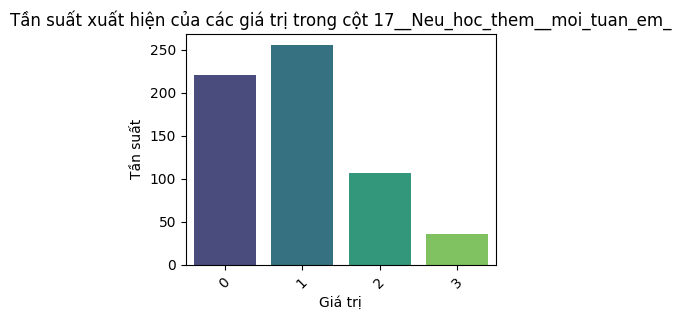

Các giá trị không thuộc cụm: []


In [580]:
plot_value_counts(df, '17__Neu_hoc_them__moi_tuan_em_')
print("Các giá trị không thuộc cụm:", invalid_values_categorize_classes)

## chuẩn hóa cột <br>18. Nếu em đi học thêm, mỗi tháng mất bao nhiêu tiên cho việc học thêm môn toán?................ đồng  (Ví dụ: 1000000 hoặc 1 triệu) <br>bằng cách phân cụm

In [581]:
# Danh sách để lưu trữ các giá trị không thuộc cụm
invalid_values_categorize_expense = []

# Hàm chuẩn hóa giá trị theo các cụm
def categorize_expense(value):

    # Nếu giá trị là một số nguyên, xử lý theo quy tắc
    if isinstance(value, int):
        # Nếu giá trị nhỏ hơn 1000, nhân với 1000
        if value < 1000:
            value *= 1000    
        # Phân loại theo giá trị đã chuẩn hóa
        if value < 500000:
            return 1  # Cụm 1: Dưới 500 nghìn
        elif 500000 <= value <= 1000000:
            return 2  # Cụm 2: Từ 500 nghìn đến 1 triệu
        elif value > 1000000:
            return 3  # Cụm 3: Trên 1 triệu
        
    # Cụm 0: Không biết, không tốn tiền, NaN
    if pd.isna(value) or value in [
        'Không biết', 'Em không biết', 'Không có', 'Không', 
        'Không học ngoài ạ 0 đồng', 'Em không học thêm', 
        'Không học thêm ở ngoài', 'Không đi học thêm học trên lớp về nhà học', 
        '0 đồng', '0đ', 'Không học thêm', 'K mất tiền', 
        'Em học online', 'Kbiet', 'Không học', 'Chưa biết', 
        'Chưa biết ', 'Ko rõ', 'Em không học thêm ', 'Không có', 'Em không đi ', 'Không có ', 
        'Không biết ', '0k', 'Em không học', 'Không học thêm ', 'Không ', 'không', 'Không đi học thêm học trên lớp về  nhà học ',
        'không', 'Không ', 'không', 'Không ','Ođ','Không học ', 'Ko biết', 'Em k biết','Không học thêm ', 'không học thêm ', 'k', 
        'Không học thêm ở ngoài ', '0đồng', '0 đồng ', 'Không học thêm ', 'Không học ngoài ạ 0đồng'
    ]:
        return 0

    # Cụm 1: Dưới 500 nghìn (500k)
    elif value in [
        '200000', '100000', '150000', '100k', '200k', '150k','200nghìn', '400 trăm'
        '240000', '300000', '400 nghìn đồng', '400.000đ', 
        '480K/1 tháng', '360 nghìn đồng', 'Mỗi tháng em mất 500 nghìn đồng', 
        '280.000đ', 'Khoảng 400 nghìn - 1 triệu', '400k', 
        '300k', '150.000VND', '4 trăm', '5 trăm', 
        '1tr2', 'Chắc khoảng 2000000', 'Tuỳ bố mẹ', '450000 là nhiều nhất', 'Tuỳ bố mẹ ', 'Không biết '
        'em ko để ý ạ…', '50k/1 buổi', 'khoảng 500.000vnđ', '400.000 VNĐ', '480000 đồng', '240 000', 
        '500 nghìn', 'Em ko biết', '500000 đồng', '480.000 đồng', '500k', 'kbiet', 'Em không biết ', 
        ' 4 trăm', '3000/tiết','Không biết ', '450k','150 000 ','50k', '400 đến 500k', '400 trăm', 'em ko để ý ạ…'
    ]:
        return 1
    
    # Cụm 2: Từ 500 nghìn đến 1 triệu
    elif value in [
        '500000', '600000', '650000', '480000', '700000', 
        '900000', '720000', '1 triệu', '1 triệu 2', 
        'Hơn 1tr', '1 triệu hoặc hơn', 'Khoảng 1 triệu', 
        'Dưới 1 triệu', '1 triệu ', '1tr120', 
        '1 triệu đến 2 triệu', 'Mỗi tháng tầm dưới 1tr', 
        '1,5 triệu', 'Mỗi tháng em mất 500 nghìn đồng', 
        'Khoảng 500.000vnđ', 'Không học thêm', '1tr', 
        '480.000 VND', '500000đ', '1 triệu rưỡi', '640000', 
        '600 nghìn', '900k', '600 trăm đồng', '600 000', '600000 đồng', 'Gần 1 triệu ', 
        '1triệu', '9 trăm', '800k', '8 trăm 40 nghìn','736000 đồng', 'Dưới 1 triệu.', '600 trăm ' , 
        '1triệu', '650k?', '600k', 'gần 1tr', '500 nghìn', '600k', '400-500 nghìn đồng', '450k', '1triệu', 
        '800k', '1triệu', '7 trăm' , '500 000', '1triệu', 'Gần 1 triệu ', 
    ]:
        return 2
    
    # Cụm 3: Trên 1 triệu
    elif value in [
        '1.5 triệu', 'Khoảng 1.5 triệu', '2 triệu', 
        '3 triệu', '4 triệu', '5 triệu', '2tr+', 
        '1 triệu 600 nghìn đồng', '900000', '1500000', 
        '2 triệu ', '1triệu ', '1triệu ', '1.2 triệu', 
        'Khoảng 1.2 triệu', '1 triệu 2', 'Trên 1 triệu', 
        '3tr', '1,5triệu ', '700000', 'Gần 1tr rưỡi', '1 tr 2', '2triệu', 
        '1,5 triệu ', '5 triệu một kỳ ', '3 triệu ', '5 triệu ','2triệu ', '3 triệu ',
        '3triệu'
    ]:
        return 3
    
    # Nếu không thuộc các cụm trên
    invalid_values_categorize_expense.append(value)
    return -1

In [582]:
df['18__Neu_em_di_hoc_them__moi_th'] = df['18__Neu_em_di_hoc_them__moi_th'].apply(categorize_expense)

C:\Users\vongu\AppData\Local\Temp\ipykernel_31224\3630094191.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




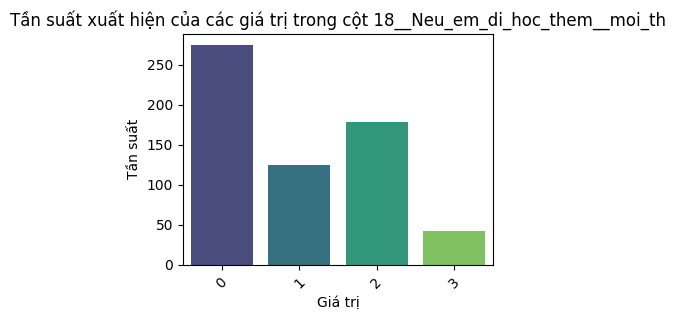

Các giá trị không thuộc cụm: []


In [583]:
plot_value_counts(df, '18__Neu_em_di_hoc_them__moi_th')
print("Các giá trị không thuộc cụm:", invalid_values_categorize_expense)

* xóa cột 2.3 đi vì dữ liệu có 600 dòng dữ liệu nhưng Column '2.3.  Yếu tố nào có ảnh hưởng đến kết quả học môn Toán của Em (liệt kê từ 1 đến 3 yếu tố)?' has 530 unique values.

In [584]:
df = df.drop(columns=['2_3___Yeu_to_nao_co_anh_huong_'], errors='ignore')

## chuẩn hóa cột dữ liệu đầu ra 19. Điểm môn toán bài kiểm tra gần đây nhất của em là................ điểm (Ví dụ: 6; 8.5)

In [585]:
# Hàm in ra giá trị không phải là dữ liệu số trong cột dữ liệu
def print_non_numeric_values(df, column_name):
    # Kiểm tra xem cột có tồn tại trong DataFrame không
    if column_name in df.columns:
        # Lọc các giá trị không phải số
        non_numeric_values = df[~df[column_name].apply(lambda x: isinstance(x, (int, float)))]
        
        # In ra giá trị không phải số
        print(f"Giá trị không phải số trong cột '{column_name}':")
        print(non_numeric_values[column_name].unique())  # In ra các giá trị duy nhất
    else:
        print(f"Cột '{column_name}' không tồn tại trong DataFrame.")


In [586]:
print_non_numeric_values(df, '19__Diem_mon_toan_bai_kiem_tra')

Giá trị không phải số trong cột '19__Diem_mon_toan_bai_kiem_tra':
['2.8' '9.8' '5.9' '9.0' '5,1Điểm' '8.8' '8.6' '8.1' '6.5' '8.7' '9.4 '
 '9.2' '8.2' '7,1: 6,6' '8.2;7.8' '8,6; 8,1' '8.0' '9.3' '7.6' '6.6' '7.4'
 '8.4' '8.9' '5 điểm ' '8.5' '6.' '5đ' 'Bài kiểm tra cuối kỳ là 6,7' '4.2'
 '5.6' 'Kiểm tra cuối kì 2:5,8' '6.4' '3.0' '7.2' '6.7' '8 điểm' '6.8'
 '9.4' '9.1' '5.1' '9.6' '4.8' '8.4; 9' '7.9' '7.3' '8,8đ' '6.0' '7.8'
 '4.0' '4.4🥲' '8.3' '7.5' '5.2' '5.0' '3đ ' '8;9,6;7,9' '8,3 ; 7,6' '7.1'
 '7.7' '4.4' '4.3' '9.8;6' '7.0' '4.7' '8.35' '7.25' 'Yy' '7,4 ; 8.8'
 '8.55' '6.95' '7.55' '6.2' '5.4' '4.6' '5.8' '4.' '7.6, 8, 8.2' '7; 7,5 '
 '6.3' '6.9' '5.5' '3.' '4 và 5']


In [587]:
# Lọc những dữ liệu không phải là chữ số
filtered_data = [
    value for value in df['19__Diem_mon_toan_bai_kiem_tra']
    if not str(value).replace('.', '', 1).replace(',', '', 1).isdigit()
]
filtered_data

['5,1Điểm', '5,1Điểm', '9.4 ', '7,1: 6,6', '8.2;7.8', '8,6; 8,1', '5 điểm ', '5đ', 'Bài kiểm tra cuối kỳ là 6,7', 'Kiểm tra cuối kì 2:5,8', '8 điểm', '8.4; 9', '8,8đ', '4.4🥲', '3đ ', '8;9,6;7,9', '8,3 ; 7,6', '9.8;6', 'Yy', '7,4 ; 8.8', '7.6, 8, 8.2', '7; 7,5 ', '4 và 5']

In [588]:
# # Danh sách để lưu trữ các giá trị không hợp lệ
# invalid_values = []
# # Hàm chuẩn hóa giá trị
# def normalize_special_cases(value):
#     value_str = str(value).strip()  # Chuyển đổi giá trị thành chuỗi và loại bỏ khoảng trắng

#     # Xử lý các trường hợp đặc biệt
#     if 'Điểm' in value_str:
#         value_str = value_str.replace('Điểm', '').strip()  # Loại bỏ 'Điểm'
#     elif 'đ' in value_str:
#         value_str = value_str.replace('đ', '').strip()  # Loại bỏ 'đ'
#     elif 'Bài kiểm tra cuối kỳ là' in value_str:
#         value_str = value_str.split('là')[-1].strip()  # Giữ lại phần sau 'là'
#     elif 'Kiểm tra cuối kì' in value_str:
#         value_str = value_str.split(':')[-1].strip()  # Giữ lại phần sau ':'
#     elif 'điểm' in value_str:
#         value_str = value_str.replace('điểm', '').strip()  # Loại bỏ 'điểm'
#     elif '🥲' in value_str:
#         value_str = value_str.replace('🥲', '').strip()  # Loại bỏ biểu tượng cảm xúc
#     elif 'và' in value_str:
#         value_str = value_str.replace('và', ' ').strip()  # Thay 'và' bằng dấu cách

#     # Thay thế dấu phẩy bằng dấu chấm
#     value_str = value_str.replace(',', '.')

#     # Xóa bỏ các ký tự không phải số và dấu chấm
#     value_str = ''.join(filter(lambda x: x.isdigit() or x == '.', value_str))

#     # Tách các giá trị và tính trung bình
#     numbers = [float(num.strip()) for num in value_str.split(';') if num.strip()]
    
#     # Nếu không có số hợp lệ, thêm vào danh sách giá trị không hợp lệ
#     if not numbers:
#         invalid_values.append(value)
#         return np.nan  # Trả về NaN nếu không có số hợp lệ

#     # Trả về trung bình của các số
#     return sum(numbers) / len(numbers)

In [589]:
# Danh sách để lưu trữ các giá trị không thuộc cụm
invalid_values_normalize_scorese = []
#  Hàm chuẩn hóa giá trị trong cột
def normalize_scores(column):
    normalized = []
    for value in column:
        # Chuyển đổi giá trị thành chuỗi và loại bỏ khoảng trắng
        value_str = str(value).strip()

        # Xử lý các trường hợp đặc biệt
        if 'Điểm' in value_str:
            value_str = value_str.replace('Điểm', '').strip()  # Loại bỏ 'Điểm'
        elif 'đ' in value_str:
            value_str = value_str.replace('đ', '').strip()  # Loại bỏ 'đ'
        elif 'Bài kiểm tra cuối kỳ là' in value_str:
            value_str = value_str.split('là')[-1].strip()  # Giữ lại phần sau 'là'
        elif 'Kiểm tra cuối kì' in value_str:
            value_str = value_str.split(':')[-1].strip()  # Giữ lại phần sau ':'
        elif 'điểm' in value_str:
            value_str = value_str.replace('điểm', '').strip()  # Loại bỏ 'điểm'
        elif '🥲' in value_str:
            value_str = value_str.replace('🥲', '').strip()  # Loại bỏ biểu tượng cảm xúc
        elif 'và' in value_str:
            value_str = value_str.replace('và', ' ').strip()  # Thay 'và' bằng dấu cách

        # Thay thế các dấu phẩy bằng dấu chấm
        value_str = value_str.replace(',', '.')

        # Xóa bỏ các ký tự không cần thiết (chỉ giữ lại số và dấu chấm)
        value_str = ''.join(filter(lambda x: x.isdigit() or x == '.', value_str))

        # Chuyển đổi giá trị thành float
        try:
            normalized_value = float(value_str)
            normalized.append(normalized_value)
        except ValueError:
            # Nếu không thể chuyển đổi, thêm NaN
            invalid_values_normalize_scorese.append(value_str)
            normalized.append(np.nan)

    return normalized

In [590]:
# Áp dụng hàm chuẩn hóa
print("Các giá trị không thuộc cụm:", invalid_values_categorize_expense)
df['19__Diem_mon_toan_bai_kiem_tra'] = normalize_scores(df['19__Diem_mon_toan_bai_kiem_tra'])


Các giá trị không thuộc cụm: []


In [591]:
def score_to_Sco(diem):
    if 8.5 <= diem <= 10:
        return 0
    elif 7.0 <= diem < 8.5:
        return 1
    elif 5.5 <= diem < 7.0:
        return 2
    elif 0 <= diem < 5.5:
        return 3
    else:
        return 999

In [592]:
for col in ['19__Diem_mon_toan_bai_kiem_tra']:
    df[col] = df[col].apply(score_to_Sco)

In [593]:
# Tính giá trị trung bình của cột 'scores', loại bỏ giá trị 999
mean_value = df['19__Diem_mon_toan_bai_kiem_tra'][df['19__Diem_mon_toan_bai_kiem_tra'] != 999].mean()

# Thay thế giá trị 999 bằng giá trị trung bình
df['19__Diem_mon_toan_bai_kiem_tra'] = df['19__Diem_mon_toan_bai_kiem_tra'].replace(999, 3)

# Làm tròn các giá trị trong cột đến 1 chữ số thập phân
df['19__Diem_mon_toan_bai_kiem_tra'] = df['19__Diem_mon_toan_bai_kiem_tra'].round(1)

In [594]:
show_infor_dataframe(df)

Column 'Ban_dang_o_tinh_nao_' has 4 unique values:
[0 2 1 3]


Column '1__Gioi_tinh' has 2 unique values:
[1 0]


Column '2__Khoi_lop' has 3 unique values:
[1 0 2]


Column '5__Ban_la_nguoi_dan_toc_gi__Vi' has 3 unique values:
[2 1 0]


Column '6___Khoang_cach_tu_nha__noi_o_' has 4 unique values:
[1 2 3 0]


Column '7___Noi_o_khi_tham_gia_hoc_hie' has 2 unique values:
[0 1]


Column '8__Nhung_phuong_tien_nao_sau_d_2' has 2 unique values:
[0 1]


Column '8__Nhung_phuong_tien_nao_sau_d_3' has 2 unique values:
[1 0]


Column '8__Nhung_phuong_tien_nao_sau_d_8' has 2 unique values:
[1 0]


Column '8__Nhung_phuong_tien_nao_sau_d_9' has 2 unique values:
[0 1]


Column '10__Trinh_do_hoc_van_cao_nhat_' has 7 unique values:
[2 1 6 3 0 5 4]


Column '11__Trinh_do_hoc_van_cao_nhat_' has 7 unique values:
[3 0 5 6 2 1 4]


Column '12__Nghe_nghiep_cua_ME_em_la' has 6 unique values:
[5 0 3 4 2 1]


Column '13__Nghe_nghiep_cua_BO_em_la' has 6 unique values:
[5 0 3 4 2 1]


Column '14__Thu_nhap_trung_bi

In [595]:
display_column_info(df)

Column: Ban_dang_o_tinh_nao_
  Data Type: int32
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 1__Gioi_tinh
  Data Type: int32
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 2__Khoi_lop
  Data Type: int32
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 5__Ban_la_nguoi_dan_toc_gi__Vi
  Data Type: int64
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 6___Khoang_cach_tu_nha__noi_o_
  Data Type: int32
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 7___Noi_o_khi_tham_gia_hoc_hie
  Data Type: int64
  Non-null Count: 619
  Total Count: 619
  Missing Values Count: 0
  Missing Values Percentage: 0.00%



Column: 8__Nhung_phuong_tien_nao_sau_d_2
  Data Type: int32
  Non-nul

# Lưu lại dữ liệu sau khi đã là sạch

In [596]:
df.to_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')

# Trực quan hóa dữ liệu

In [597]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

In [598]:
# Khởi tạo dictionary để lưu kết quả của từng cột
result_dict = {}

# Duyệt qua từng cột trong danh sách và tính tỷ lệ phần trăm
for column in columns_to_calculate_percentage:
    try:
        result_dict[column] = calculate_percentage(df_visualize, column)
    except KeyError:
        print(f"Cột '{column}' không tồn tại trong DataFrame")

# In kết quả
for column, result_df in result_dict.items():
    print(f"Tỷ lệ phần trăm xuất hiện trong cột '{column}':")
    print(result_df)
    print("\n")  # Thêm khoảng trắng giữa các kết quả cho dễ đọc

Cột '8__Nhung_phuong_tien_nao_sau_d' không tồn tại trong DataFrame
Cột '8__Nhung_phuong_tien_nao_sau_d_4' không tồn tại trong DataFrame
Cột '8__Nhung_phuong_tien_nao_sau_d_5' không tồn tại trong DataFrame
Cột '8__Nhung_phuong_tien_nao_sau_d_6' không tồn tại trong DataFrame
Cột '8__Nhung_phuong_tien_nao_sau_d_7' không tồn tại trong DataFrame
Cột '9__Hien_nay_em_dang_song_voi_a' không tồn tại trong DataFrame
Cột '21__Em_co_tham_gia_cau_lac_bo_' không tồn tại trong DataFrame
Cột '22__Hay_cho_biet_muc_do_thuong' không tồn tại trong DataFrame
Tỷ lệ phần trăm xuất hiện trong cột 'Ban_dang_o_tinh_nao_':
   Value  Percentage
0      1   36.995153
1      2   33.279483
2      0   16.155089
3      3   13.570275


Tỷ lệ phần trăm xuất hiện trong cột '1__Gioi_tinh':
   Value  Percentage
0      1    58.15832
1      0    41.84168


Tỷ lệ phần trăm xuất hiện trong cột '2__Khoi_lop':
   Value  Percentage
0      2   41.195477
1      1   41.033926
2      0   17.770598


Tỷ lệ phần trăm xuất hiện trong cột

## Biểu đồ trực quan phân bố dữ liệu

In [599]:
# Tính toán số hàng và cột dựa trên số lượng cột trong df_visualize
columns_to_plot = df_visualize.columns
n_cols = 3  # Giả sử bạn muốn có 3 cột trong mỗi hàng
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

# Khởi tạo subplot
fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=columns_to_plot)

# Sử dụng một palette màu từ Plotly
color_palette = px.colors.qualitative.Plotly

# Vẽ biểu đồ phân phối cho từng biến
for i, column in enumerate(columns_to_plot):
    row = i // n_cols + 1
    col = i % n_cols + 1
    color = color_palette[i % len(color_palette)]

    fig.add_trace(
        go.Histogram(x=df_visualize[column], marker=dict(color=color), name=column, showlegend=False),
        row=row, col=col
    )

    fig.update_xaxes(title_text=f'{column}', row=row, col=col)
    fig.update_yaxes(title_text=f'{column} Count', row=row, col=col)

# Chỉnh layout và hiển thị biểu đồ
fig.update_layout(
    height=400 * n_rows,  # Điều chỉnh chiều cao tổng thể của biểu đồ
    width=1200,  # Điều chỉnh chiều rộng tổng thể của biểu đồ
    title_text="Biểu Đồ Phân Bố Dữ Liệu",
    showlegend=False,
    template="plotly_white"  # Sử dụng template trắng để biểu đồ trông sạch sẽ hơn
)
fig.show()

## biểu đồ box plot

In [600]:
# Tính toán số hàng và cột dựa trên số lượng cột trong df_visualize
columns_to_plot = df_visualize.columns
n_cols = 3  # Giả sử bạn muốn có 4 cột trong mỗi hàng
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

# Khởi tạo subplot
fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=columns_to_plot)

# Tạo một danh sách các màu sắc ngẫu nhiên cho biểu đồ
random_colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in columns_to_plot]

# Vẽ box plot cho từng cột
for i, (column, color) in enumerate(zip(columns_to_plot, random_colors)):
    row = i // n_cols + 1
    col = i % n_cols + 1

    fig.add_trace(
        go.Box(y=df_visualize[column], marker=dict(color=color), name=column, showlegend=False),
        row=row, col=col
    )

    fig.update_xaxes(title_text=f'{column} Box Plot', row=row, col=col)
    fig.update_yaxes(title_text=f'{column} Value', row=row, col=col)

# Chỉnh layout và hiển thị biểu đồ
fig.update_layout(height=400 * n_rows, width=1100, title_text="Biểu Đồ Box Plot Các Cột Dữ Liệu")
fig.show()


                                  Ban_dang_o_tinh_nao_  1__Gioi_tinh  \
Ban_dang_o_tinh_nao_                          1.000000     -0.029828   
1__Gioi_tinh                                 -0.029828      1.000000   
2__Khoi_lop                                   0.478867     -0.014911   
5__Ban_la_nguoi_dan_toc_gi__Vi               -0.337921      0.077256   
6___Khoang_cach_tu_nha__noi_o_               -0.038513     -0.042754   
...                                                ...           ...   
VI__CONG_NGHE__Em_thuong_dung_               -0.046922     -0.008055   
VI__CONG_NGHE__Em_tu_hoc_toan_               -0.068060      0.017557   
VI__CONG_NGHE__Nha_truong_co_d                0.004626     -0.009621   
VI__CONG_NGHE__Em_duoc_phep_su               -0.113517     -0.049478   
VI__CONG_NGHE__Giao_vien_Toan__4              0.003129     -0.027225   

                                  2__Khoi_lop  5__Ban_la_nguoi_dan_toc_gi__Vi  \
Ban_dang_o_tinh_nao_                 0.478867         

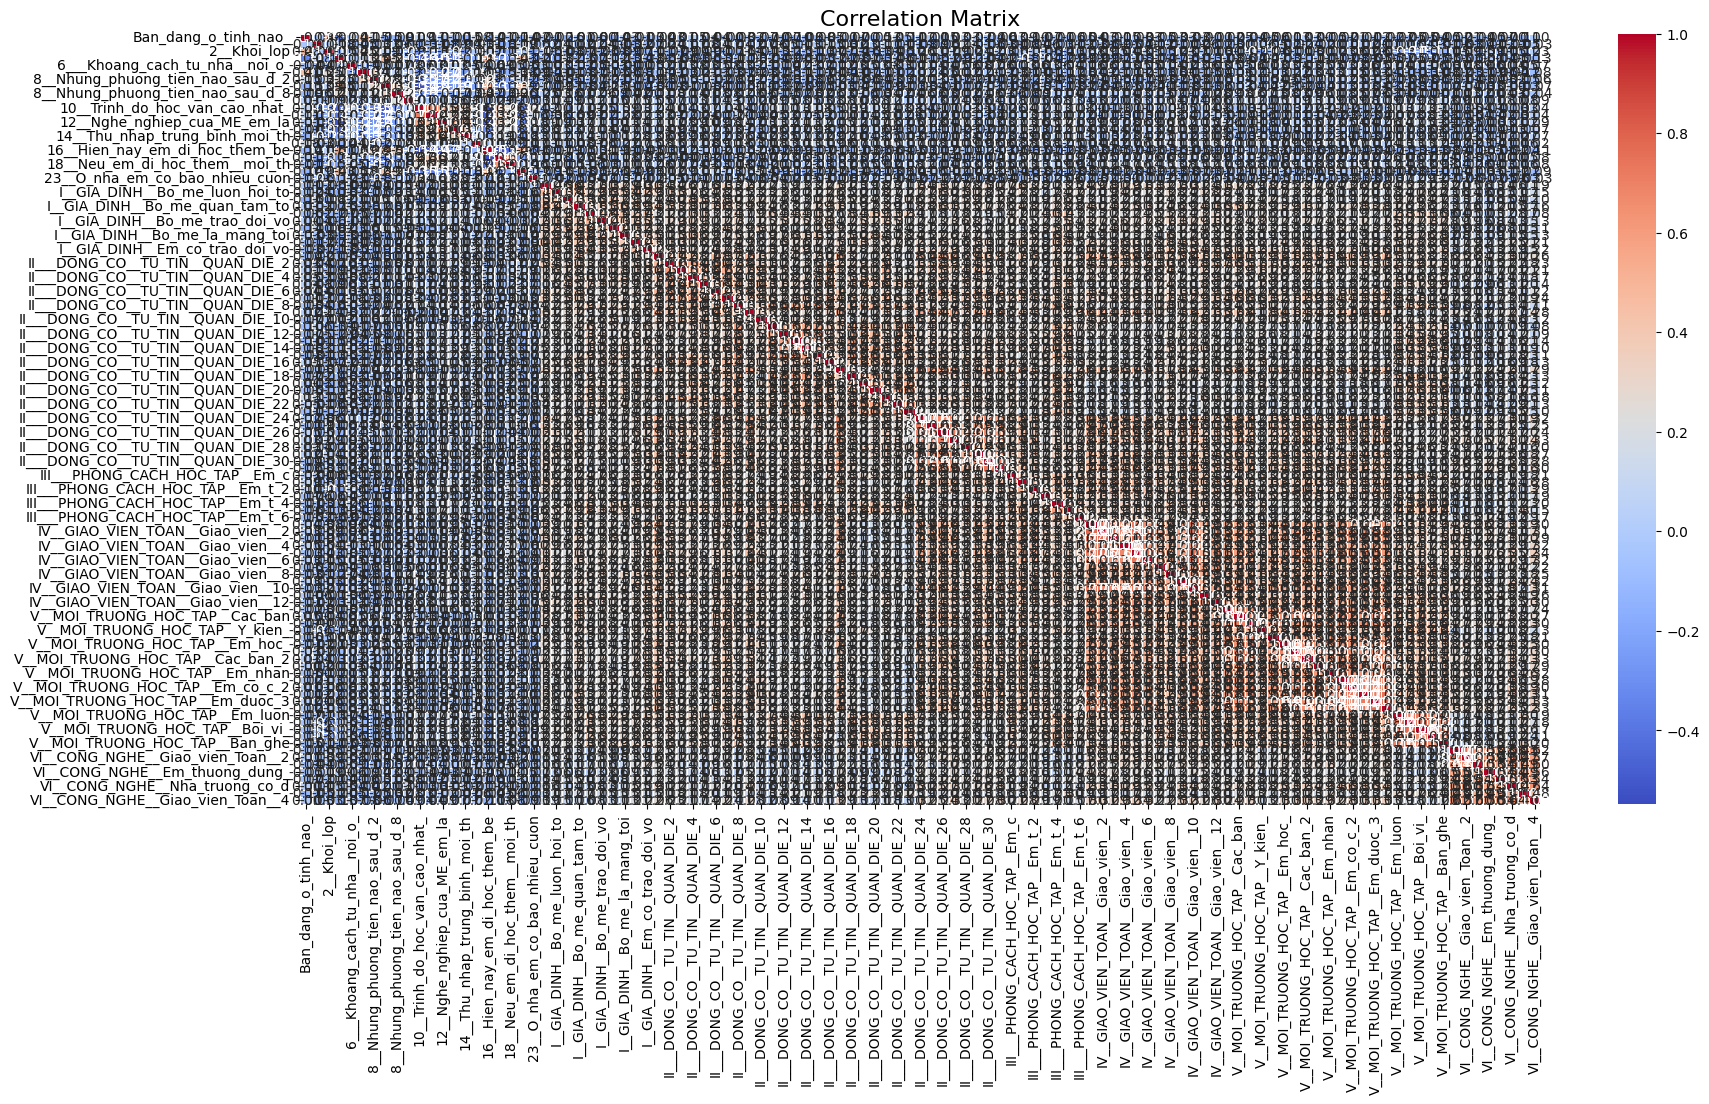

In [601]:
corr_matrix = df_visualize.corr()
print(corr_matrix)
# Vẽ biểu đồ heatmap của ma trận tương quan
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()


                                  19__Diem_mon_toan_bai_kiem_tra
19__Diem_mon_toan_bai_kiem_tra                          1.000000
16__Hien_nay_em_di_hoc_them_be                          0.456922
5__Ban_la_nguoi_dan_toc_gi__Vi                          0.427546
8__Nhung_phuong_tien_nao_sau_d_3                        0.394680
8__Nhung_phuong_tien_nao_sau_d_8                        0.261248
...                                                          ...
17__Neu_hoc_them__moi_tuan_em_                         -0.229466
13__Nghe_nghiep_cua_BO_em_la                           -0.260020
12__Nghe_nghiep_cua_ME_em_la                           -0.293038
10__Trinh_do_hoc_van_cao_nhat_                         -0.351042
11__Trinh_do_hoc_van_cao_nhat_                         -0.351263

[109 rows x 1 columns]


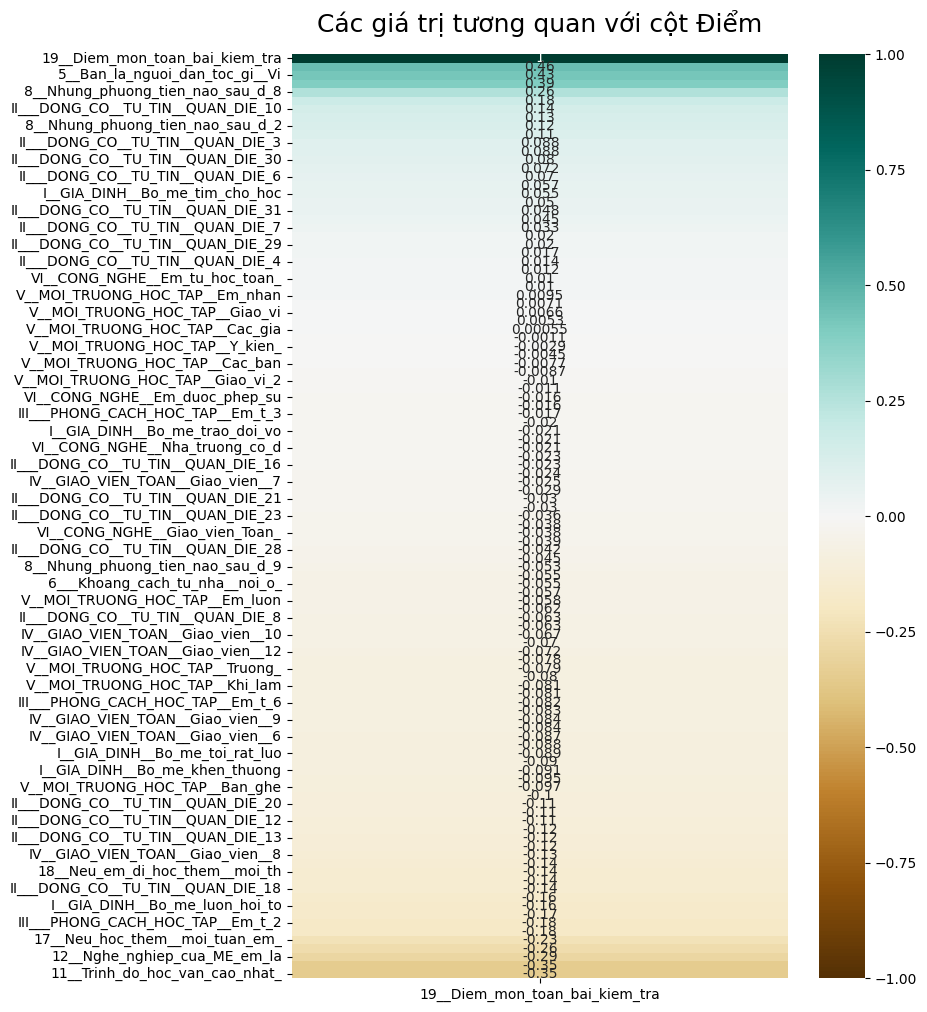

In [602]:
correlation_matrix = df_visualize.corr()
correlation = correlation_matrix[['19__Diem_mon_toan_bai_kiem_tra']].sort_values(by='19__Diem_mon_toan_bai_kiem_tra', ascending=False)

print(correlation)

# Trực quan hóa các giá trị tương quan bằng heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Các giá trị tương quan với cột Điểm', fontdict={'fontsize':18}, pad=16)
plt.show()

                                   19__Diem_mon_toan_bai_kiem_tra
II___DONG_CO__TU_TIN__QUAN_DIE                          -0.008729
II___DONG_CO__TU_TIN__QUAN_DIE_24                        0.007110
II___DONG_CO__TU_TIN__QUAN_DIE_26                       -0.004529
V__MOI_TRUONG_HOC_TAP__Cac_ban                          -0.007698
V__MOI_TRUONG_HOC_TAP__Giao_vi                           0.006596
V__MOI_TRUONG_HOC_TAP__Y_kien_                          -0.002942
V__MOI_TRUONG_HOC_TAP__Em_nhan                           0.009535
V__MOI_TRUONG_HOC_TAP__Cac_gia                           0.000555
V__MOI_TRUONG_HOC_TAP__Em_duoc_3                        -0.001094
VI__CONG_NGHE__Giao_vien_Toan__2                         0.005312


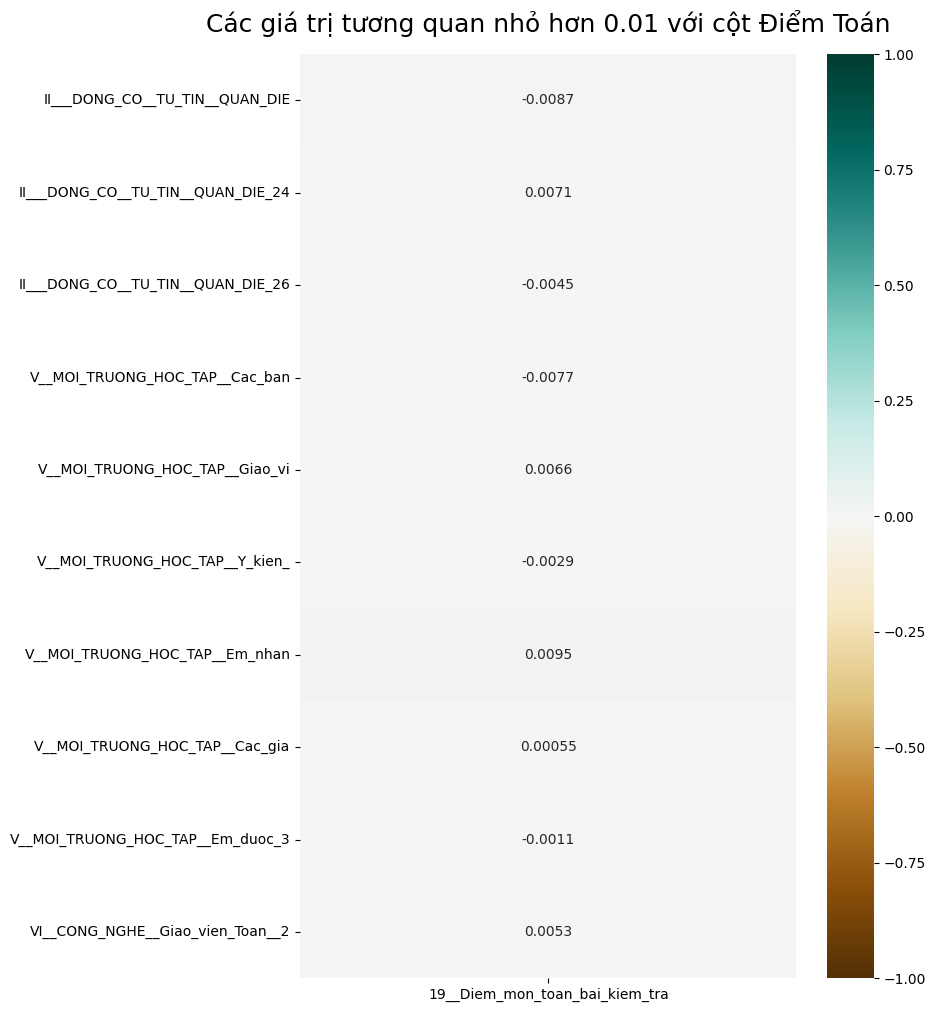

In [603]:
# Đọc dữ liệu
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

# Tính ma trận tương quan
correlation_matrix = df_visualize.corr()

# Lọc các giá trị tương quan nhỏ hơn 0.01
filtered_correlation_low = correlation_matrix[['19__Diem_mon_toan_bai_kiem_tra']][abs(correlation_matrix['19__Diem_mon_toan_bai_kiem_tra']) <= 0.01]

# In ra các giá trị tương quan đã lọc
print(filtered_correlation_low)

# Trực quan hóa các giá trị tương quan bằng heatmap
plt.figure(figsize=(8, 12))
heatmap_low = sns.heatmap(filtered_correlation_low, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_low.set_title('Các giá trị tương quan nhỏ hơn 0.01 với cột Điểm Toán', fontdict={'fontsize':18}, pad=16)
plt.show()

* xóa các cột sau vì có mức độ tương quan thấp đến với kết quả đầu ra

In [604]:
df = df.drop(columns=['II___DONG_CO__TU_TIN__QUAN_DIE', 'II___DONG_CO__TU_TIN__QUAN_DIE_24', 'II___DONG_CO__TU_TIN__QUAN_DIE_26',
                      'V__MOI_TRUONG_HOC_TAP__Cac_ban', 'V__MOI_TRUONG_HOC_TAP__Giao_vi', 'V__MOI_TRUONG_HOC_TAP__Y_kien_',
                       'V__MOI_TRUONG_HOC_TAP__Em_nhan', 'V__MOI_TRUONG_HOC_TAP__Cac_gia ','V__MOI_TRUONG_HOC_TAP__Em_duoc_3 ',
                       'VI__CONG_NGHE__Giao_vien_Toan__2'   ], errors='ignore')

df.to_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')

                                   19__Diem_mon_toan_bai_kiem_tra
19__Diem_mon_toan_bai_kiem_tra                           1.000000
16__Hien_nay_em_di_hoc_them_be                           0.456922
5__Ban_la_nguoi_dan_toc_gi__Vi                           0.427546
8__Nhung_phuong_tien_nao_sau_d_3                         0.394680
8__Nhung_phuong_tien_nao_sau_d_8                         0.261248
7___Noi_o_khi_tham_gia_hoc_hie                           0.176161
II___DONG_CO__TU_TIN__QUAN_DIE_10                        0.143442
V__MOI_TRUONG_HOC_TAP__Em_duoc                           0.130129
8__Nhung_phuong_tien_nao_sau_d_2                         0.120479
I__GIA_DINH__Bo__me_muon_toi_t                           0.112719
V__MOI_TRUONG_HOC_TAP__Nhung_t                          -0.104444
II___DONG_CO__TU_TIN__QUAN_DIE_20                       -0.107606
15__Muc_do_thuong_xuyen_em_giu                          -0.107983
II___DONG_CO__TU_TIN__QUAN_DIE_12                       -0.110871
23__O_nha_

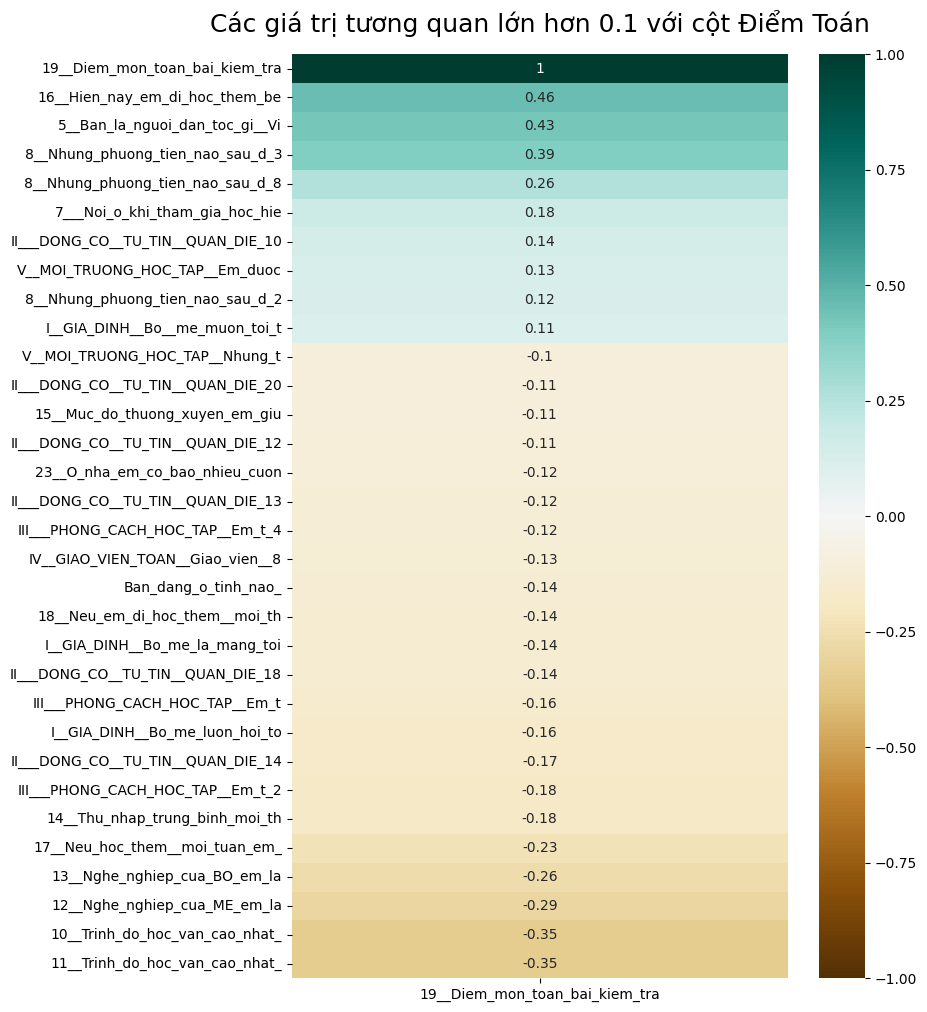

In [605]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

# Tính ma trận tương quan
correlation_matrix = df_visualize.corr()

# Lọc các giá trị tương quan lớn hơn 0.1
filtered_correlation = correlation_matrix[['19__Diem_mon_toan_bai_kiem_tra']][abs(correlation_matrix['19__Diem_mon_toan_bai_kiem_tra']) > 0.1]
filtered_correlation = filtered_correlation.sort_values(by='19__Diem_mon_toan_bai_kiem_tra', ascending=False)

# In ra các giá trị tương quan đã lọc
print(filtered_correlation)

# Trực quan hóa các giá trị tương quan bằng heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(filtered_correlation, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Các giá trị tương quan lớn hơn 0.1 với cột Điểm Toán', fontdict={'fontsize':18}, pad=16)
plt.show()


C:\Users\vongu\AppData\Local\Temp\ipykernel_31224\3630094191.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




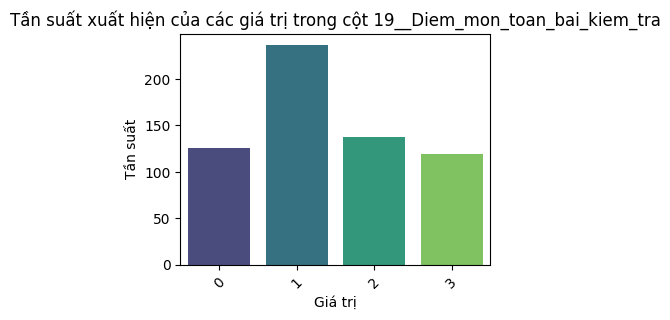

Các giá trị không thuộc cụm: []


In [606]:
plot_value_counts(df_visualize, '19__Diem_mon_toan_bai_kiem_tra')
print("Các giá trị không thuộc cụm:", invalid_values_categorize_classes)

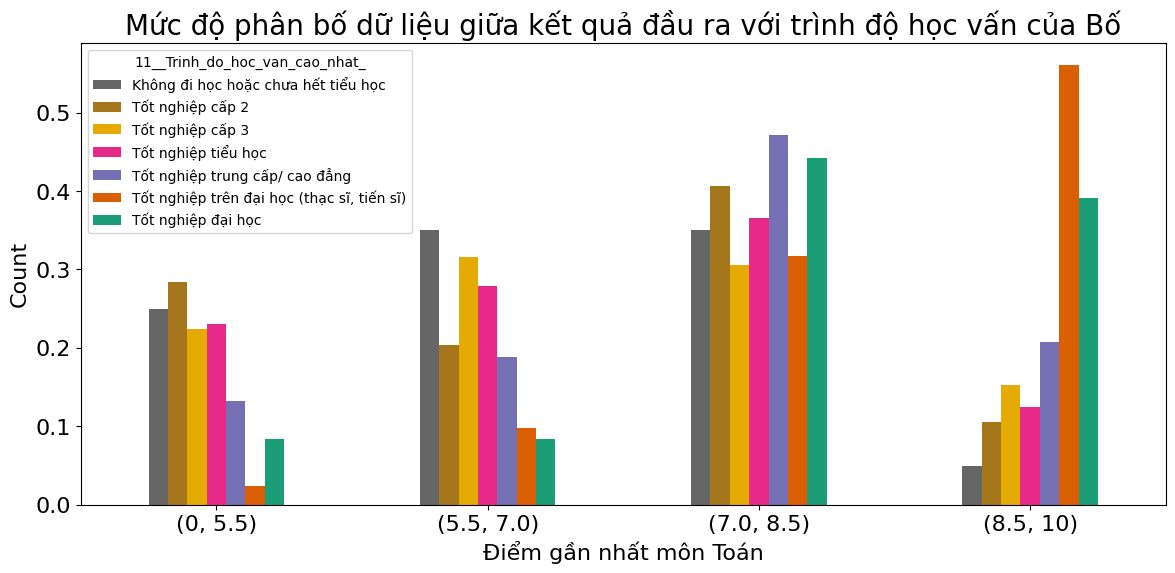

In [607]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"

# Load mô hình LabelEncoder
label_encoder = joblib.load('B:/DoAnTotNghiep/DATA_Giaoduc/label_encoder/HocToan/11__Trinh_do_hoc_van_cao_nhat__labelencoder.pkl')  # Thay đổi đường dẫn nếu cần

# Giả sử df_visualize là DataFrame đã được tạo trước đó
df_visualize['11__Trinh_do_hoc_van_cao_nhat_'] = label_encoder.inverse_transform(df_visualize['11__Trinh_do_hoc_van_cao_nhat_'])

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['11__Trinh_do_hoc_van_cao_nhat_'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa kết quả đầu ra với trình độ học vấn của Bố', fontsize=20)
plt.xlabel('Điểm gần nhất môn Toán', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()

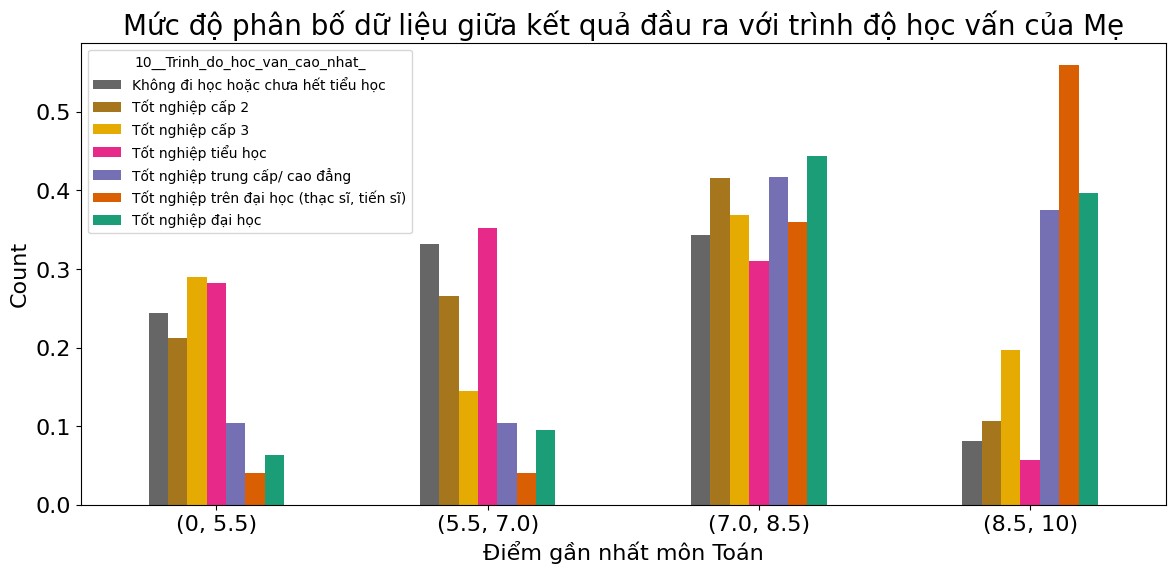

In [608]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"

# Load mô hình LabelEncoder
label_encoder = joblib.load('B:/DoAnTotNghiep/DATA_Giaoduc/label_encoder/HocToan/10__Trinh_do_hoc_van_cao_nhat__labelencoder.pkl')  # Thay đổi đường dẫn nếu cần

# Giả sử df_visualize là DataFrame đã được tạo trước đó
df_visualize['10__Trinh_do_hoc_van_cao_nhat_'] = label_encoder.inverse_transform(df_visualize['10__Trinh_do_hoc_van_cao_nhat_'])

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['10__Trinh_do_hoc_van_cao_nhat_'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa kết quả đầu ra với trình độ học vấn của Mẹ', fontsize=20)
plt.xlabel('Điểm gần nhất môn Toán', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()

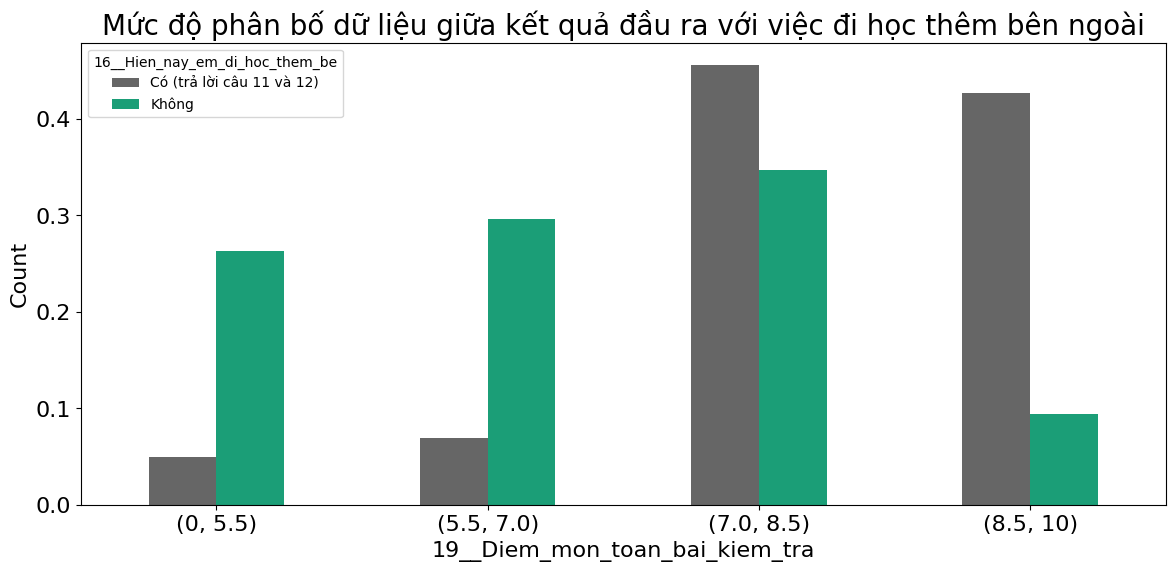

In [609]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"

# Load mô hình LabelEncoder
label_encoder = joblib.load('B:/DoAnTotNghiep/DATA_Giaoduc/label_encoder/HocToan/16__Hien_nay_em_di_hoc_them_be_labelencoder.pkl') 

# Giả sử df_visualize là DataFrame đã được tạo trước đó
df_visualize['16__Hien_nay_em_di_hoc_them_be'] = label_encoder.inverse_transform(df_visualize['16__Hien_nay_em_di_hoc_them_be'])

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['16__Hien_nay_em_di_hoc_them_be'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa kết quả đầu ra với việc đi học thêm bên ngoài', fontsize=20)
plt.xlabel('19__Diem_mon_toan_bai_kiem_tra', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()

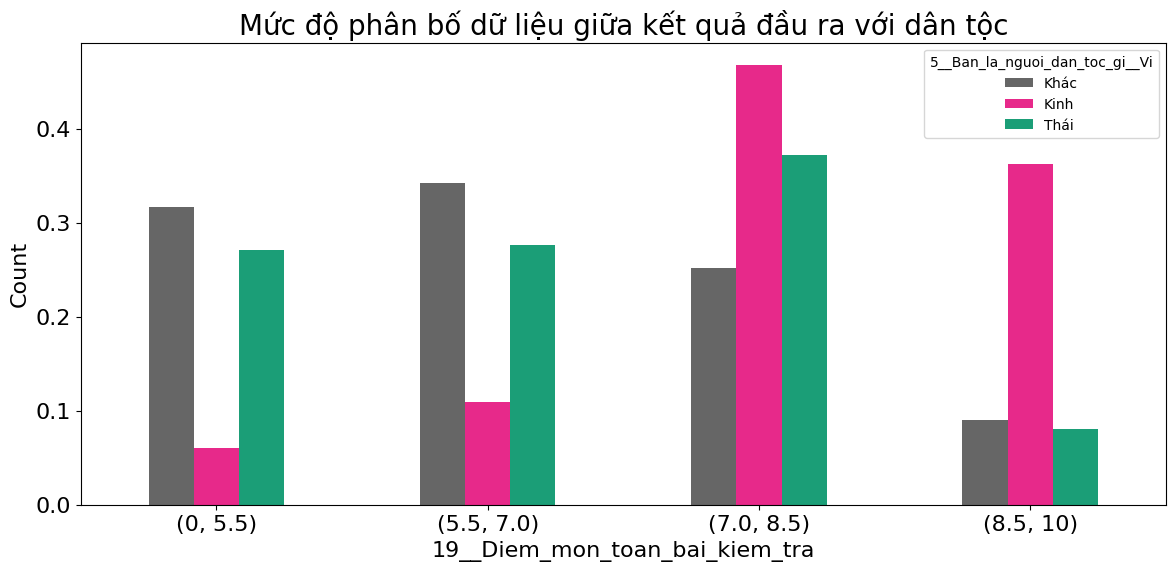

In [610]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"
    
def dan_toc(value):
    if value == 0:
        return "Kinh"
    elif value == 1:
        return "Thái"
    elif value == 2:
        return "Khác"

    
df_visualize['5__Ban_la_nguoi_dan_toc_gi__Vi'] = df_visualize['5__Ban_la_nguoi_dan_toc_gi__Vi'].apply(dan_toc)

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['5__Ban_la_nguoi_dan_toc_gi__Vi'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa kết quả đầu ra với dân tộc', fontsize=20)
plt.xlabel('19__Diem_mon_toan_bai_kiem_tra', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()

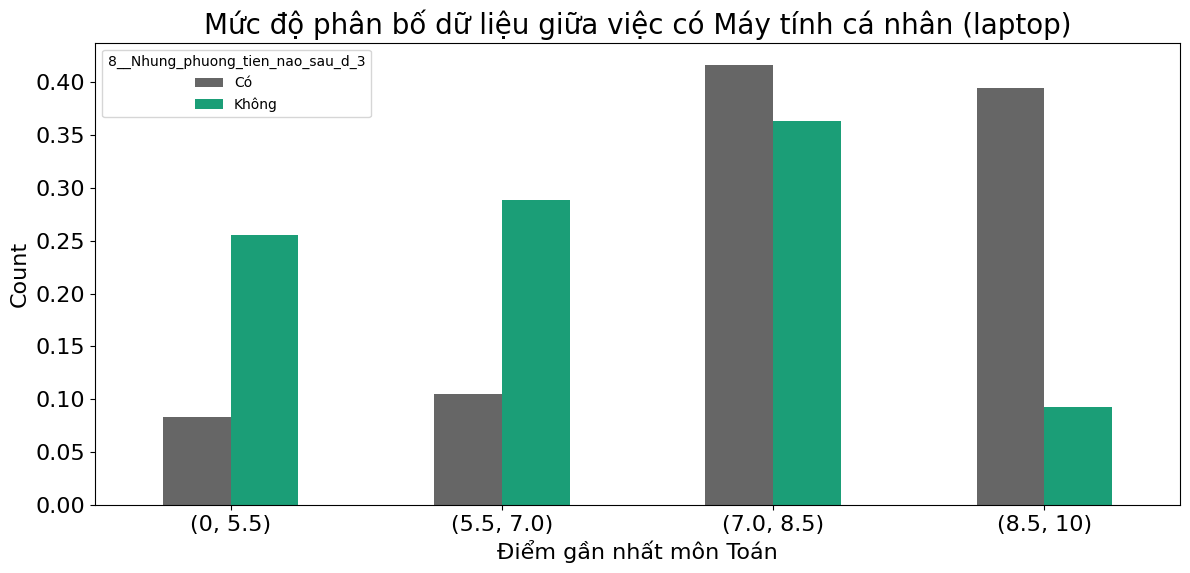

In [611]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"
    
# Load mô hình LabelEncoder
label_encoder = joblib.load('B:/DoAnTotNghiep/DATA_Giaoduc/label_encoder/HocToan/8__Nhung_phuong_tien_nao_sau_d_3_labelencoder.pkl') 

# Giả sử df_visualize là DataFrame đã được tạo trước đó
df_visualize['8__Nhung_phuong_tien_nao_sau_d_3'] = label_encoder.inverse_transform(df_visualize['8__Nhung_phuong_tien_nao_sau_d_3'])

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['8__Nhung_phuong_tien_nao_sau_d_3'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa việc có Máy tính cá nhân (laptop)', fontsize=20)
plt.xlabel('Điểm gần nhất môn Toán', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()

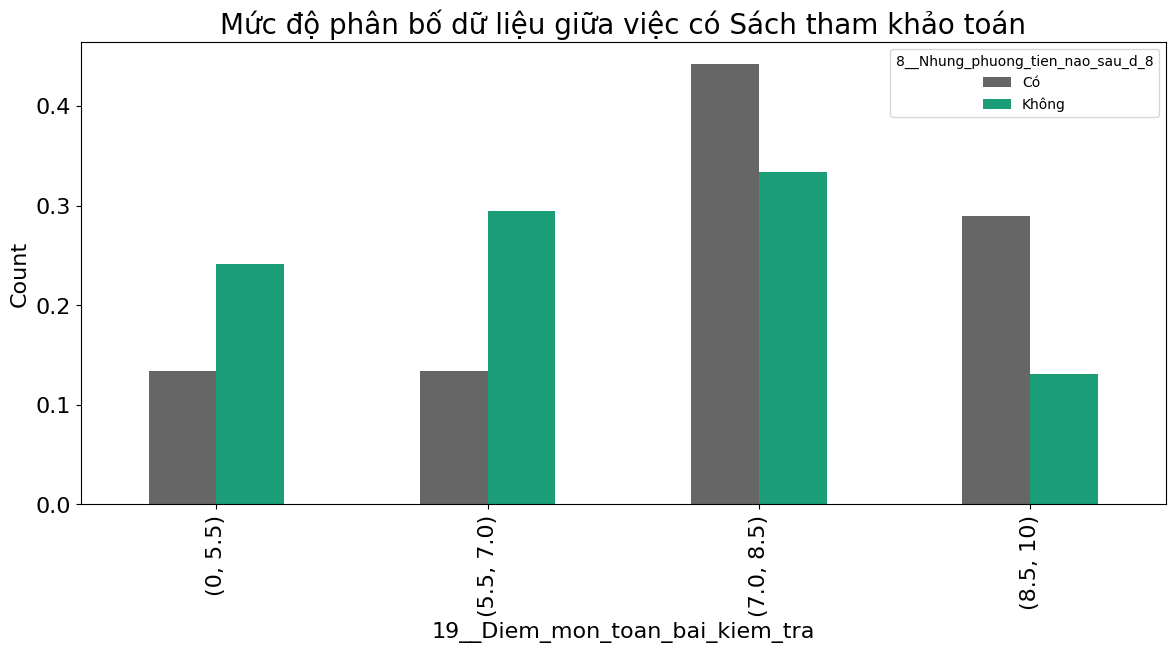

In [612]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"
    
# Load mô hình LabelEncoder
label_encoder = joblib.load('B:/DoAnTotNghiep/DATA_Giaoduc/label_encoder/HocToan/8__Nhung_phuong_tien_nao_sau_d_8_labelencoder.pkl') 

# Giả sử df_visualize là DataFrame đã được tạo trước đó
df_visualize['8__Nhung_phuong_tien_nao_sau_d_8'] = label_encoder.inverse_transform(df_visualize['8__Nhung_phuong_tien_nao_sau_d_8'])

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['8__Nhung_phuong_tien_nao_sau_d_8'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa việc có Sách tham khảo toán', fontsize=20)
plt.xlabel('19__Diem_mon_toan_bai_kiem_tra', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

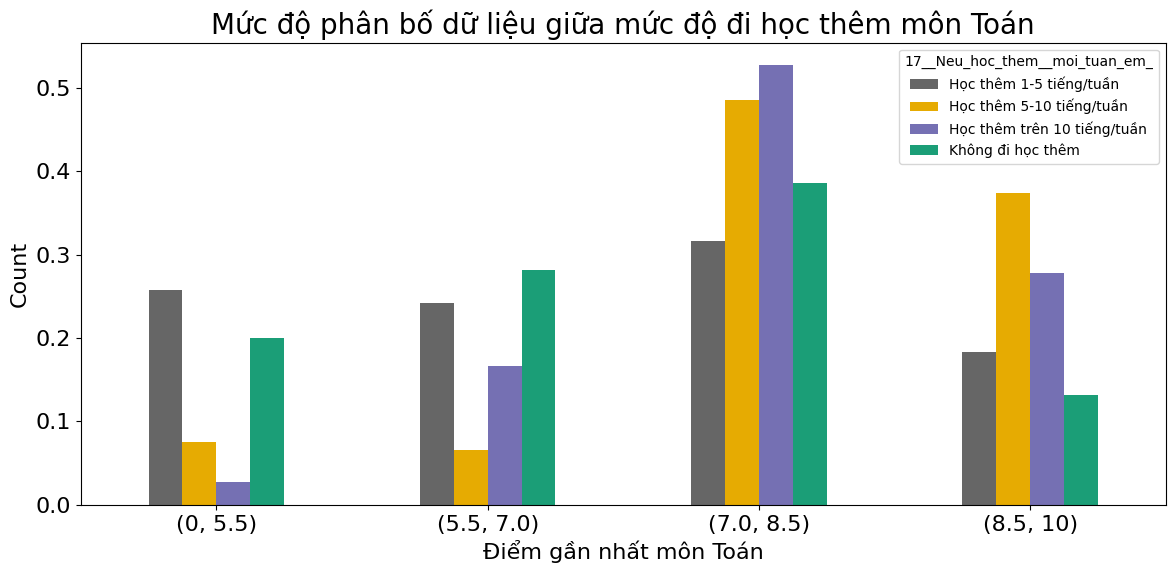

In [613]:
df_visualize = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_visualize = df_visualize.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

def Sco_to_score(diem):
    if diem == 0:
        return "(8.5, 10)"
    elif diem == 1:
        return "(7.0, 8.5)"
    elif diem == 2:
        return "(5.5, 7.0)"
    elif diem == 3:
        return "(0, 5.5)"
    else:
        return "Không xác định"
    

def reverse_function(cluster):
    if isinstance(cluster, int):
        if cluster == 0:
            return "Không đi học thêm"  # Cụm 0
        elif cluster == 1:
            return "Học thêm 1-5 tiếng/tuần"  # Cụm 1
        elif cluster == 2:
            return "Học thêm 5-10 tiếng/tuần"  # Cụm 2
        elif cluster == 3:
            return "Học thêm trên 10 tiếng/tuần"  # Cụm 3
    return "Giá trị không hợp lệ"

# Áp dụng hàm score_to_Sco để mã hóa ngược
df_visualize['19__Diem_mon_toan_bai_kiem_tra'] = df_visualize['19__Diem_mon_toan_bai_kiem_tra'].apply(Sco_to_score)
df_visualize['17__Neu_hoc_them__moi_tuan_em_'] = df_visualize['17__Neu_hoc_them__moi_tuan_em_'].apply(reverse_function)

# Tính toán phân phối
perc = lambda col: col / col.sum()
# index = [0, 1, 2, 3]
higher_tab = pd.crosstab(index=df_visualize['19__Diem_mon_toan_bai_kiem_tra'], columns=df_visualize['17__Neu_hoc_them__moi_tuan_em_'])
higher_perc = higher_tab.apply(perc)

# Vẽ biểu đồ
higher_perc.plot.bar(colormap="Dark2_r", figsize=(14, 6), fontsize=16)
plt.title('Mức độ phân bố dữ liệu giữa mức độ đi học thêm môn Toán', fontsize=20)
plt.xlabel('Điểm gần nhất môn Toán', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.show()


# Huấn luyện mô hình

In [696]:
df_model = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_model = df_model.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

# Random Forest Classifier

In [697]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, confusion_matrix, auc
from sklearn.metrics import make_scorer,accuracy_score,precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import UndefinedMetricWarning

In [698]:
X = df_model.drop(columns=['19__Diem_mon_toan_bai_kiem_tra'])
y = df_model['19__Diem_mon_toan_bai_kiem_tra']

Iteration :99, Current accuracy: 51.61290322580645, Current f1 : 0.48506429701326195


*Accuracy is: 47.8494623655914
*f1 score is:  0.4471083179197989
random_state is  6585979


 *the ROC curve: 


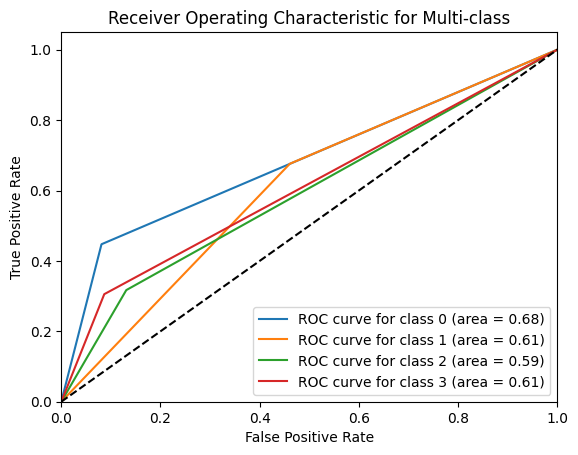

 *the confusion matrix 


<Axes: >

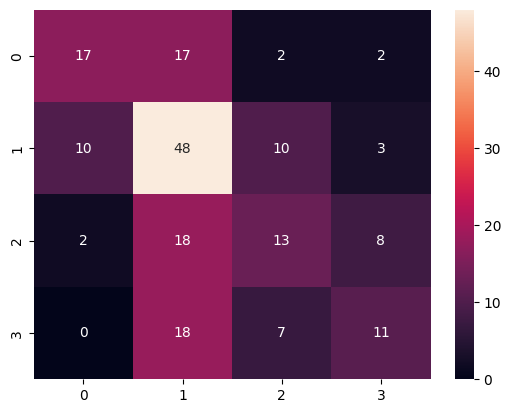

In [742]:
max_iteration = 100
maxF1 = 0
maxAccuracy = 0
optimal_state = 0
for k in range(max_iteration):
    print ('Iteration :'+str(k)+', Current accuracy: '+str(maxAccuracy)+ ', Current f1 : '+str(maxF1), end="\r")
    split_state = np.random.randint(1,100000000)-1
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, stratify=y,random_state=split_state)
    random_fores = RandomForestClassifier()
    random_fores.fit(x_train,y_train)
    y_pred=random_fores.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)*100
    
    if (accuracy>maxAccuracy and f1>maxF1):
        maxF1 = f1 
        maxAccuracy = accuracy
        optimal_state = split_state
    
optimal_state = optimal_state

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, stratify=y ,random_state=optimal_state)
random_fores= RandomForestClassifier()
random_fores.fit(x_train,y_train)
y_pred=random_fores.predict(x_test)
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)*100
print('\n\n\n*Accuracy is: '+str(accuracy)+'\n*f1 score is: ',f1)

print ('random_state is ',optimal_state)


#ploting the roc_curve

print ( '\n\n *the ROC curve: ')

# Giả sử bạn đã có y_test và y_pred từ mô hình random_fores
# Biến đổi y_test thành định dạng nhị phân cho nhiều lớp
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

# Tính toán và vẽ đường cong ROC cho từng lớp
for i in range(n_classes):
    fpositif, tpositif, thresholds = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(fpositif, tpositif, label='ROC curve for class {0} (area = {1:0.2f})'.format(i, auc(fpositif, tpositif)))

# Vẽ đường chéo
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()
yt_random_fores,yp_random_fores= y_test,y_pred
#visualizig the confusion matrix:

print (' *the confusion matrix ')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

In [743]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=optimal_state)

In [744]:
from sklearn.metrics import f1_score, classification_report

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
n_estimators_values = range(1, 100)
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

best_n_estimators = None  
best_f1_score = 0.0 

for n_estimators in n_estimators_values:
    RFC_Model = RandomForestClassifier(n_estimators=n_estimators, random_state=optimal_state)
    RFC_Model.fit(X_train, y_train)
    
    y_pred_Rf = RFC_Model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred_Rf)
    precision = precision_score(y_test, y_pred_Rf, average='macro')
    recall = recall_score(y_test, y_pred_Rf, average='macro')
    f1 = f1_score(y_test, y_pred_Rf, average='macro')
    
    print(f"n_estimators:{n_estimators} with accuracy:{accuracy}")

    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)
    
    if accuracy > best_f1_score:
        best_f1_score = accuracy
        best_n_estimators = n_estimators


RFC_Model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
RFC_Model.fit(X_train, y_train)

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best F1 score: {best_f1_score}")

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(n_estimators_values), y=accuracy_values, mode='lines+markers', name='Accuracy'))
fig.add_trace(go.Scatter(x=list(n_estimators_values), y=precision_values, mode='lines+markers', name='Precision'))
fig.add_trace(go.Scatter(x=list(n_estimators_values), y=recall_values, mode='lines+markers', name='Recall'))
fig.add_trace(go.Scatter(x=list(n_estimators_values), y=f1_values, mode='lines+markers', name='F1-Score'))

# Highlight the best n_estimators with a vertical line
fig.add_vline(x=best_n_estimators, line=dict(color='red', dash='dash'), annotation_text=f'Best n_estimators ({best_n_estimators})', annotation_position="top right")

fig.update_layout(
    title='Performance Metrics vs n_estimators for RandomForest Classifier',
    xaxis_title='n_estimators',
    yaxis_title='Value',
    legend_title='Metrics',
    hovermode='x unified'
)

fig.show()

n_estimators:1 with accuracy:0.27956989247311825
n_estimators:2 with accuracy:0.2903225806451613
n_estimators:3 with accuracy:0.3602150537634409
n_estimators:4 with accuracy:0.3709677419354839
n_estimators:5 with accuracy:0.3709677419354839
n_estimators:6 with accuracy:0.34946236559139787
n_estimators:7 with accuracy:0.3602150537634409
n_estimators:8 with accuracy:0.3548387096774194
n_estimators:9 with accuracy:0.3763440860215054
n_estimators:10 with accuracy:0.3924731182795699
n_estimators:11 with accuracy:0.3870967741935484
n_estimators:12 with accuracy:0.42473118279569894
n_estimators:13 with accuracy:0.3924731182795699
n_estimators:14 with accuracy:0.41397849462365593
n_estimators:15 with accuracy:0.41397849462365593
n_estimators:16 with accuracy:0.41935483870967744
n_estimators:17 with accuracy:0.40860215053763443
n_estimators:18 with accuracy:0.41935483870967744
n_estimators:19 with accuracy:0.3978494623655914
n_estimators:20 with accuracy:0.41935483870967744
n_estimators:21 with

In [745]:
y_pred = RFC_Model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"f1_score: {f1_score}")
print("Classification Report:\n", report)

Accuracy: 0.43548387096774194
f1_score: 0.38518158104543104
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.39      0.43        38
           1       0.47      0.65      0.54        71
           2       0.39      0.37      0.38        41
           3       0.26      0.14      0.18        36

    accuracy                           0.44       186
   macro avg       0.40      0.39      0.39       186
weighted avg       0.42      0.44      0.42       186



In [754]:
# Extract feature importances
feature_importances = RFC_Model.feature_importances_
features = X_train.columns

# Create a DataFrame to hold feature importances
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
fig_importances = go.Figure()

fig_importances.add_trace(go.Bar(
    x=importance_df['Feature'],
    y=importance_df['Importance'],
    marker_color='royalblue'
))

fig_importances.update_layout(
    title='Độ quan trọng của các đặc trưng từ mô hình RandomForest Classifier',
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis_tickangle=-45
)

fig_importances.show()

In [755]:
print("Độ quan trọng của các đặc trưng:")
print(importance_df.to_string(index=False))

Độ quan trọng của các đặc trưng:
                          Feature  Importance
     13__Nghe_nghiep_cua_BO_em_la    0.033482
   10__Trinh_do_hoc_van_cao_nhat_    0.032369
             Ban_dang_o_tinh_nao_    0.031177
   11__Trinh_do_hoc_van_cao_nhat_    0.027785
   5__Ban_la_nguoi_dan_toc_gi__Vi    0.023860
   16__Hien_nay_em_di_hoc_them_be    0.022524
   6___Khoang_cach_tu_nha__noi_o_    0.017919
   14__Thu_nhap_trung_binh_moi_th    0.017351
                      2__Khoi_lop    0.016866
     12__Nghe_nghiep_cua_ME_em_la    0.015960
   18__Neu_em_di_hoc_them__moi_th    0.015958
 8__Nhung_phuong_tien_nao_sau_d_3    0.015763
II___DONG_CO__TU_TIN__QUAN_DIE_18    0.014820
   17__Neu_hoc_them__moi_tuan_em_    0.014784
   I__GIA_DINH__Bo__me_muon_toi_t    0.014314
II___DONG_CO__TU_TIN__QUAN_DIE_14    0.013903
   VI__CONG_NGHE__Em_duoc_phep_su    0.013881
   VI__CONG_NGHE__Em_tu_hoc_toan_    0.013069
II___DONG_CO__TU_TIN__QUAN_DIE_20    0.012934
   I__GIA_DINH__Em_co_trao_doi_vo    0.012873
 

In [756]:
# Lưu mô hình thành file
model_filename = 'model/HocToan/RFC_Model.pkl'
joblib.dump(RFC_Model, model_filename)

print(f'Mô hình đã được lưu vào file {model_filename}')

Mô hình đã được lưu vào file model/HocToan/RFC_Model.pkl


# XGBOOST

In [706]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [707]:

optimal_state = None
best_accuracy = float('-inf')
best_f1_score = float('-inf')

# Chuyển đổi X và y thành mảng NumPy
X_np = X.values if isinstance(X, pd.DataFrame) else X
y_np = y.values if isinstance(y, pd.Series) else y

# Số lần chia trong StratifiedKFold
n_splits = 10

for _ in range(100):
    state = np.random.randint(1, 100000000) - 1
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=state)
    
    accuracies = []
    f1_scores = []
    
    for train_index, test_index in skf.split(X_np, y_np):
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]
        
        model = XGBClassifier(objective='binary:logistic')
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    
    avg_accuracy = np.mean(accuracies)
    avg_f1_score = np.mean(f1_scores)
    
    # Kiểm tra và cập nhật nếu kết quả tốt hơn
    if avg_accuracy > best_accuracy or avg_f1_score > best_f1_score:
        best_accuracy = avg_accuracy
        best_f1_score = avg_f1_score
        optimal_state = state

print(f'Optimal random_state: {optimal_state}')
print(f'Best Average Accuracy: {best_accuracy}')
print(f'Best Average F1 Score: {best_f1_score}')

Optimal random_state: 72817222
Best Average Accuracy: 0.4863828662083554
Best Average F1 Score: 0.481623442180649


In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=optimal_state)

In [663]:

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
# Khởi tạo danh sách để lưu các giá trị chỉ số đánh giá
n_estimators_values = range(1, 100, 2)
train_accuracy_values = []
test_accuracy_values = []
train_precision_values = []
test_precision_values = []
train_recall_values = []
test_recall_values = []
train_f1_values = []
test_f1_values = []
best_n_estimators = None
best_f1 = 0

for n_estimators in n_estimators_values:
    model = XGBClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred, average='macro')
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    train_accuracy_values.append(train_accuracy)
    test_accuracy_values.append(test_accuracy)
    train_precision_values.append(train_precision)
    test_precision_values.append(test_precision)
    train_recall_values.append(train_recall)
    test_recall_values.append(test_recall)
    train_f1_values.append(train_f1)
    test_f1_values.append(test_f1)
    
    print(f'train_accuracy_values: {train_accuracy}')
    print(f'test_accuracy_values: {test_accuracy}')
    print(f'train_precision_values: {train_precision}')
    print(f'test_precision_values: {test_precision}')
    print(f'train_recall_values: {train_precision}')
    print(f'test_recall_values: {test_precision}')
    print(f'train_f1_values: {train_precision}')
    print(f'test_f1_values: {test_precision}')
    print('--------------------------')
    
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_n_estimators = n_estimators

XGBC_Model = XGBClassifier(n_estimators=n_estimators, learning_rate=0.1, max_depth=5)
XGBC_Model.fit(X_train, y_train)

print(f'Best n_estimators: {best_n_estimators}')
print(f'Best F1 Score: {best_f1}')

# Vẽ biểu đồ bằng Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(n_estimators_values), y=train_accuracy_values, mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(n_estimators_values), y=test_accuracy_values, mode='lines+markers', name='Test Accuracy'))
fig.add_trace(go.Scatter(x=list(n_estimators_values), y=train_f1_values, mode='lines+markers', name='Train F1 Score'))
fig.add_trace(go.Scatter(x=list(n_estimators_values), y=test_f1_values, mode='lines+markers', name='Test F1 Score'))

# Đánh dấu vị trí best_n_estimators bằng một đường thẳng màu đỏ
fig.add_vline(x=best_n_estimators, line=dict(color='red', dash='dash'), name=f'Best n_estimators ({best_n_estimators})')


fig.update_layout(
    title='Performance Metrics vs n_estimators for XGBoost Classifier',
    xaxis_title='n_estimators',
    yaxis_title='Value',
    legend_title='Metrics'
)

fig.show()

train_accuracy_values: 0.7505773672055427
test_accuracy_values: 0.3978494623655914
train_precision_values: 0.7520694281781182
test_precision_values: 0.3967679512516469
train_recall_values: 0.7520694281781182
test_recall_values: 0.3967679512516469
train_f1_values: 0.7520694281781182
test_f1_values: 0.3967679512516469
--------------------------
train_accuracy_values: 0.8175519630484989
test_accuracy_values: 0.4032258064516129
train_precision_values: 0.8219728800611154
test_precision_values: 0.406920584689572
train_recall_values: 0.8219728800611154
test_recall_values: 0.406920584689572
train_f1_values: 0.8219728800611154
test_f1_values: 0.406920584689572
--------------------------
train_accuracy_values: 0.836027713625866
test_accuracy_values: 0.46774193548387094
train_precision_values: 0.832807721725975
test_precision_values: 0.48337864241795214
train_recall_values: 0.832807721725975
test_recall_values: 0.48337864241795214
train_f1_values: 0.832807721725975
test_f1_values: 0.4833786424179

In [664]:

y_pred = XGBC_Model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"f1_score: {f1_score}")
print("Classification Report:\n", report)

Accuracy: 0.4946236559139785
f1_score: 0.4709599356492012
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.34      0.44        38
           1       0.46      0.68      0.55        71
           2       0.47      0.46      0.47        41
           3       0.60      0.33      0.43        36

    accuracy                           0.49       186
   macro avg       0.54      0.45      0.47       186
weighted avg       0.52      0.49      0.48       186



In [665]:
# Extract feature importances
feature_importances = XGBC_Model.feature_importances_
features = X_train.columns

# Create a DataFrame to hold feature importances
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
fig_importances = go.Figure()

fig_importances.add_trace(go.Bar(
    x=importance_df['Feature'],
    y=importance_df['Importance'],
    marker_color='royalblue'
))

fig_importances.update_layout(
    title='Độ quan trọng của các đặc trưng từ mô hình XGBClassifier Classifier',
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis_tickangle=-45
)

fig_importances.show()

In [666]:
print("Độ quan trọng của các đặc trưng:")
print(importance_df.to_string(index=False))

Độ quan trọng của các đặc trưng:
                          Feature  Importance
 8__Nhung_phuong_tien_nao_sau_d_3    0.037375
   16__Hien_nay_em_di_hoc_them_be    0.030334
 V__MOI_TRUONG_HOC_TAP__Em_duoc_2    0.020478
   5__Ban_la_nguoi_dan_toc_gi__Vi    0.020012
 IV__GIAO_VIEN_TOAN__Giao_vien__4    0.018157
     13__Nghe_nghiep_cua_BO_em_la    0.017542
II___DONG_CO__TU_TIN__QUAN_DIE_18    0.017136
   V__MOI_TRUONG_HOC_TAP__Truong_    0.016710
 IV__GIAO_VIEN_TOAN__Giao_vien__5    0.016565
II___DONG_CO__TU_TIN__QUAN_DIE_15    0.016303
             Ban_dang_o_tinh_nao_    0.015660
 IV__GIAO_VIEN_TOAN__Giao_vien__3    0.014947
   I__GIA_DINH__Bo_me_la_mang_toi    0.014028
 V__MOI_TRUONG_HOC_TAP__Em_co_c_2    0.013281
   I__GIA_DINH__Em_co_trao_doi_vo    0.012937
II___DONG_CO__TU_TIN__QUAN_DIE_30    0.012907
   I__GIA_DINH__Bo_me_khen_thuong    0.012751
   I__GIA_DINH__Bo_me_toi_rat_luo    0.012202
 II___DONG_CO__TU_TIN__QUAN_DIE_3    0.012118
 II___DONG_CO__TU_TIN__QUAN_DIE_2    0.012096
 

In [667]:
# Lưu mô hình thành file
model_filename = 'model/HocToan/XGBC_Model.pkl'
joblib.dump(XGBC_Model, model_filename)

print(f'Mô hình đã được lưu vào file {model_filename}')

Mô hình đã được lưu vào file model/HocToan/XGBC_Model.pkl


# Mô hình Multilayer Perceptron 

In [668]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="keras")


In [ ]:
# # Hàm tạo mô hình
# def create_model():
#     model = Sequential()
#     model.add(Dense(256, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(0.001)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#     model.add(Dense(4, activation='softmax'))
    
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Khởi tạo biến lưu kết quả tốt nhất
# best_f1 = 0
# best_random_state_NLP = None

# # Duyệt qua các giá trị random_state từ 1 đến 100
# for random_state in range(1, 101):
#     # Chia tách dữ liệu
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
    
#     # Tạo mô hình
#     model = create_model()
    
#     # Huấn luyện mô hình
#     model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)  # Sử dụng ít epoch để tiết kiệm thời gian
    
#     # Đánh giá mô hình trên tập kiểm tra
#     y_pred = np.argmax(model.predict(X_test), axis=1)
#     f1 = f1_score(y_test, y_pred, average='weighted')
    
#     # Cập nhật random_state tốt nhất nếu F1-score cao hơn
#     if f1 > best_f1:
#         best_f1 = f1
#         best_random_state_NLP = random_state

#     print(f"Random State: {random_state}, F1 Score: {f1:.4f}")

# # In ra random_state tốt nhất
# print("Best F1 Score:", best_f1)
# print("Best Random State:", best_random_state_NLP)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 1, F1 Score: 0.3440
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 2, F1 Score: 0.3588
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Random State: 3, F1 Score: 0.3615
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random State: 4, F1 Score: 0.3781
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Random State: 5, F1 Score: 0.3647
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random State: 6, F1 Score: 0.3732
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Random State: 7, F1 Score: 0.3994
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 8, F1 Score: 0.3133
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random State: 9, F1 Score: 0.2881
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 10, F1 Score: 0.3706
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 11, F1 Score: 0.3562
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Random State: 12, F1 Score: 0.3212
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 13, F1 Score: 0.3449
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random State: 14, F1 S

In [709]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=76390884, stratify=y)

In [ ]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2
# from sklearn.metrics import f1_score, accuracy_score, recall_score
# import tensorflow as tf

# # Thiết lập phạm vi các giá trị cần thử nghiệm
# dropout_rates = [0.2, 0.3, 0.4]
# l2_rates = [0.0001, 0.001, 0.005]
# learning_rates = [0.0001, 0.0005, 0.001]
# batch_sizes = [32, 64, 128]

# # Để lưu trữ mô hình tốt nhất
# best_f1 = 0
# best_model = None
# best_params = {}

# # Hàm tạo mô hình
# def create_model(dropout_rate, l2_rate, learning_rate):
#     model = Sequential()
#     model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_rate)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_rate)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_rate)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(4, activation='softmax'))
    
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Lặp qua các giá trị của các tham số
# for dropout_rate in dropout_rates:
#     for l2_rate in l2_rates:
#         for learning_rate in learning_rates:
#             for batch_size in batch_sizes:
#                 print(f"Training with dropout={dropout_rate}, l2={l2_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

#                 # Tạo mô hình
#                 model = create_model(dropout_rate, l2_rate, learning_rate)

#                 # Callbacks
#                 early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#                 reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
                
#                 # Huấn luyện mô hình
#                 history = model.fit(
#                     X_train, y_train,
#                     validation_data=(X_test, y_test),
#                     epochs=100,
#                     batch_size=batch_size,
#                     callbacks=[early_stopping, reduce_lr],
#                     verbose=0
#                 )

#                 # Đánh giá mô hình
#                 y_pred = np.argmax(model.predict(X_test), axis=1)
#                 f1 = f1_score(y_test, y_pred, average='weighted')
                
#                 # Lưu lại mô hình tốt nhất
#                 if f1 > best_f1:
#                     best_f1 = f1
#                     best_model = model
#                     best_params = {
#                         "dropout_rate": dropout_rate,
#                         "l2_rate": l2_rate,
#                         "learning_rate": learning_rate,
#                         "batch_size": batch_size
#                     }
#                     model.save("model/HocToan/MLP_Model1.h5")  # Lưu lại mô hình tốt nhất
#                     model_filename = 'model/HocToan/MLP_Model0.pkl'
#                     joblib.dump(model, model_filename)

#                 print(f"F1 Score: {f1:.4f} with params: dropout={dropout_rate}, l2={l2_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

# # Hiển thị các tham số tốt nhất
# print("Best F1 Score:", best_f1)
# print("Best Parameters:", best_params)


Training with dropout=0.2, l2=0.0001, learning_rate=0.0001, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


F1 Score: 0.2792 with params: dropout=0.2, l2=0.0001, learning_rate=0.0001, batch_size=32
Training with dropout=0.2, l2=0.0001, learning_rate=0.0001, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


F1 Score: 0.4006 with params: dropout=0.2, l2=0.0001, learning_rate=0.0001, batch_size=64
Training with dropout=0.2, l2=0.0001, learning_rate=0.0001, batch_size=128
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
F1 Score: 0.2882 with params: dropout=0.2, l2=0.0001, learning_rate=0.0001, batch_size=128
Training with dropout=0.2, l2=0.0001, learning_rate=0.0005, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3337 with params: dropout=0.2, l2=0.0001, learning_rate=0.0005, batch_size=32
Training with dropout=0.2, l2=0.0001, learning_rate=0.0005, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3908 with params: dropout=0.2, l2=0.0001, learning_rate=0.0005, batch_size=64
Training with dropout=0.2, l2=0.0001, learning_rate=0.0005, batch_size=128
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


F1 Score: 0.4016 with params: dropout=0.2, l2=0.0001, learning_rate=0.0005, batch_size=128
Training with dropout=0.2, l2=0.0001, learning_rate=0.001, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


F1 Score: 0.4146 with params: dropout=0.2, l2=0.0001, learning_rate=0.001, batch_size=32
Training with dropout=0.2, l2=0.0001, learning_rate=0.001, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
F1 Score: 0.4042 with params: dropout=0.2, l2=0.0001, learning_rate=0.001, batch_size=64
Training with dropout=0.2, l2=0.0001, learning_rate=0.001, batch_size=128
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3476 with params: dropout=0.2, l2=0.0001, learning_rate=0.001, batch_size=128
Training with dropout=0.2, l2=0.001, learning_rate=0.0001, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
F1 Score: 0.3762 with params: dropout=0.2, l2=0.001, learning_rate=0.0001, batch_size=32
Training with dropout=0.2, l2=0.001, learning_rate=0.0001, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3205 with params: dropout=0.2, l2=0.001, learning_rate=0.0001, batch_size=64
Training with dropout=0.2, l2=0.001, learning_rate=0.0001, batch_size=128
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/st

F1 Score: 0.4183 with params: dropout=0.2, l2=0.005, learning_rate=0.0005, batch_size=128
Training with dropout=0.2, l2=0.005, learning_rate=0.001, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.4146 with params: dropout=0.2, l2=0.005, learning_rate=0.001, batch_size=32
Training with dropout=0.2, l2=0.005, learning_rate=0.001, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3782 with params: dropout=0.2, l2=0.005, learning_rate=0.001, batch_size=64
Training with dropout=0.2, l2=0.005, learning_rate=0.001, batch_size=128
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


F1 Score: 0.4556 with params: dropout=0.2, l2=0.005, learning_rate=0.001, batch_size=128
Training with dropout=0.3, l2=0.0001, learning_rate=0.0001, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3479 with params: dropout=0.3, l2=0.0001, learning_rate=0.0001, batch_size=32
Training with dropout=0.3, l2=0.0001, learning_rate=0.0001, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
F1 Score: 0.2398 with params: dropout=0.3, l2=0.0001, learning_rate=0.0001, batch_size=64
Training with dropout=0.3, l2=0.0001, learning_rate=0.0001, batch_size=128
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
F1 Score: 0.2957 with params: dropout=0.3, l2=0.0001, learning_rate=0.0001, batch_size=128
Training with dropout=0.3, l2=0.0001, learning_rate=0.0005, batch_size=32
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
F1 Score: 0.3824 with params: dropout=0.3, l2=0.0001, learning_rate=0.0005, batch_size=32
Training with dropout=0.3, l2=0.0001, learning_rate=0.0005, batch_size=64
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s

In [710]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.metrics_history = []

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        y_pred = np.argmax(self.model.predict(val_x), axis=1)
        
        f1 = f1_score(val_y, y_pred, average='weighted')
        accuracy = accuracy_score(val_y, y_pred)
        recall = recall_score(val_y, y_pred, average='weighted')
        
        self.metrics_history.append((f1, accuracy, recall))
        
        print(f'Epoch {epoch + 1} - F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}')


In [711]:
metrics_callback = MetricsCallback(validation_data=(X_test, y_test))
# Tạo mô hình
NLP_model = create_model(0.4, 0.005, 0.001)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
                
# Huấn luyện mô hình
history = NLP_model.fit(
                    X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping, reduce_lr, metrics_callback],
                    verbose=0
                )

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1 - F1 Score: 0.3279, Accuracy: 0.3710, Recall: 0.3710
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 2 - F1 Score: 0.3096, Accuracy: 0.3495, Recall: 0.3495
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 3 - F1 Score: 0.2976, Accuracy: 0.3495, Recall: 0.3495
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 4 - F1 Score: 0.2997, Accuracy: 0.3548, Recall: 0.3548
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 5 - F1 Score: 0.3201, Accuracy: 0.3817, Recall: 0.3817
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 6 - F1 Score: 0.3147, Accuracy: 0.3817, Recall: 0.3817
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 7 - F1 Score: 0.3109, Accuracy: 0.3710, Recall: 0.3710
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 8 - F1 Score: 0.2962, Accuracy: 0.3548, Recall: 0.3548
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 9 - F1 Score: 0.3239, Accuracy: 0.3710, Recall: 0.3710
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 10 - F1 Score: 0.3542, Accuracy: 0.4032, Recall: 0.4032
6/6 ━━━━━

In [712]:

# Tách các thông số từ metrics_history
f1_scores, accuracy, recalls = zip(*metrics_callback.metrics_history)

# Tạo figure
fig = go.Figure()

# Thêm Accuracy
fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines+markers',
    name='Accuracy (Validation)',
    line=dict(color='violet')
))

# Thêm các trace cho F1 Score, Accuracy và Recall
fig.add_trace(go.Scatter(x=list(range(1, len(f1_scores) + 1)), 
                         y=f1_scores, 
                         mode='lines+markers', 
                         name='F1 Score', 
                         line=dict(width=2)))
fig.add_trace(go.Scatter(x=list(range(1, len(recalls) + 1)), 
                         y=recalls, 
                         mode='lines+markers', 
                         name='Recall', 
                         line=dict(width=2)))

# Cấu hình layout
fig.update_layout(title='Performance Metrics vs epoch for Multilayer Perception',
                  xaxis_title='Epochs',
                  yaxis_title='Score',
                  legend=dict(x=0, y=1, traceorder='normal'),
                  template='plotly_white')

# Hiển thị biểu đồ
fig.show()

In [713]:
# Check if y_test is one-dimensional
if len(y_test.shape) == 1:
    y_test_labels = y_test  # Already class labels
else:
    # Convert from one-hot encoding to class labels
    y_test_labels = np.argmax(y_test, axis=1)

# Predict class labels
y_pred = NLP_model.predict(X_test)

# If y_pred is one-hot encoded, convert to class labels as well
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
else:
    y_pred_labels = y_pred  # Already class labels

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
report = classification_report(y_test_labels, y_pred_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.43548387096774194
F1 Score: 0.4191321106186093
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.34      0.37        38
           1       0.44      0.54      0.48        71
           2       0.34      0.24      0.29        41
           3       0.53      0.56      0.54        36

    accuracy                           0.44       186
   macro avg       0.43      0.42      0.42       186
weighted avg       0.43      0.44      0.43       186



In [714]:
# # Fit the best NLP_model
# NLP_model.fit(X_train, y_train)

# # Calculate permutation importance
# result = permutation_importance(NLP_model, X_test, y_test, n_repeats=30, random_state=42)

# # Extract feature importances and create a DataFrame
# importance_df = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': result.importances_mean
# })

# # Sort by importance
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Plot feature importances
# fig_importances = go.Figure()

# fig_importances.add_trace(go.Bar(
#     x=importance_df['Feature'],
#     y=importance_df['Importance'],
#     marker_color='royalblue'
# ))

# fig_importances.update_layout(
#     title='Độ quan trọng của các đặc trưng từ mô hình KerasClassifier',
#     xaxis_title='Feature',
#     yaxis_title='Importance',
#     xaxis_tickangle=-45
# )

# fig_importances.show()


In [715]:
# Lưu mô hình thành file
model_filename = 'model/HocToan/MLP_Model.pkl'
joblib.dump(NLP_model, model_filename)

print(f'Mô hình đã được lưu vào file {model_filename}')

Mô hình đã được lưu vào file model/HocToan/MLP_Model.pkl


# Mô hình CNN

In [642]:
df_model = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_model = df_model.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])

In [643]:
X = df_model.drop(columns=['19__Diem_mon_toan_bai_kiem_tra'])
y = df_model['19__Diem_mon_toan_bai_kiem_tra']

In [644]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=optimal_state)

In [645]:
class F1ScoreHistory(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        self.recalls = []

    def on_train_begin(self, logs=None):
        self.f1_scores = []
        self.recalls = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Dữ liệu xác thực
        val_data = self.validation_data
        if val_data is not None:
            # Dự đoán trên tập validation
            val_predict = self.model.predict(val_data[0])
            val_predict_classes = np.argmax(val_predict, axis=1)
            
            # Tính F1 Score
            f1 = f1_score(val_data[1], val_predict_classes, average='weighted')
            self.f1_scores.append(f1)
            logs['val_f1_score'] = f1  # Lưu F1 Score vào logs
            
            # Tính Recall
            recall = recall_score(val_data[1], val_predict_classes, average='weighted')
            self.recalls.append(recall)
            logs['val_recall'] = recall  # Lưu Recall vào logs

    def on_train_end(self, logs=None):
        self.model.history.history['val_f1_score'] = self.f1_scores
        self.model.history.history['val_recall'] = self.recalls  # Lưu Recall vào history

    def set_params(self, params):
        super().set_params(params)
        self.validation_data = params.get('validation_data')

In [646]:
# Khởi tạo mô hình CNN
CNN_model = Sequential()
CNN_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Dropout(0.5))

CNN_model.add(Conv1D(128, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Dropout(0.5))

CNN_model.add(Flatten())
CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(4, activation='softmax'))  # Sử dụng 4 nhãn

# Biên dịch mô hình
CNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Thiết lập Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Khởi tạo F1ScoreHistory
f1_score_history = F1ScoreHistory(validation_data=(X_test, y_test))

# Khởi tạo F1ScoreHistory
metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

# Huấn luyện mô hình
history = CNN_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, metrics_callback]
)

# Dự đoán trên tập kiểm tra
y_pred = CNN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính toán các chỉ số
f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/stepep - accuracy: 0.2969 - loss: 1.56
Epoch 1 - F1 Score: 0.2084, Accuracy: 0.3790, Recall: 0.3790
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2973 - loss: 1.5581 - val_accuracy: 0.3790 - val_loss: 1.3428
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step ep - accuracy: 0.3953 - loss: 1.331
Epoch 2 - F1 Score: 0.2600, Accuracy: 0.3468, Recall: 0.3468
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3939 - loss: 1.3318 - val_accuracy: 0.3468 - val_loss: 1.3243
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step ep - accuracy: 0.3635 - loss: 1.296
Epoch 3 - F1 Score: 0.2719, Accuracy: 0.3871, Recall: 0.3871
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3634 - loss: 1.2963 - val_accuracy: 0.3871 - val_loss: 1.3024
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step ep - accuracy: 0.3485 - loss: 1.293
Epoch 4 - F1 Score: 0.2738, Accuracy: 0.3226, Recall: 0.3226
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3617 - loss: 1.2856

In [647]:
# Dự đoán trên tập kiểm tra
y_pred = CNN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính toán Accuracy và Recall
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f'F1 Score: {f1_score(y_test, y_pred_classes, average="weighted"):.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
F1 Score: 0.4135
Accuracy: 0.4274
Recall: 0.4274


In [648]:

# Tách các thông số từ metrics_history
f1_scores, accuracy, recalls = zip(*metrics_callback.metrics_history)

# Tạo figure
fig = go.Figure()

# Thêm Accuracy
fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines+markers',
    name='Accuracy (Validation)',
    line=dict(color='violet')
))

# Thêm các trace cho F1 Score, Accuracy và Recall
fig.add_trace(go.Scatter(x=list(range(1, len(f1_scores) + 1)), 
                         y=f1_scores, 
                         mode='lines+markers', 
                         name='F1 Score', 
                         line=dict(width=2)))
fig.add_trace(go.Scatter(x=list(range(1, len(recalls) + 1)), 
                         y=recalls, 
                         mode='lines+markers', 
                         name='Recall', 
                         line=dict(width=2)))

# Cấu hình layout
fig.update_layout(title='Performance Metrics vs epoch for Convolutional Neural Networks ',
                  xaxis_title='Epochs',
                  yaxis_title='Score',
                  legend=dict(x=1, y=1, traceorder='normal'),
                  template='plotly_white')

# Hiển thị biểu đồ
fig.show()

In [649]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines+markers',
    name='Accuracy (Validation)',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines+markers',
    name='Loss',
    line=dict(color='violet')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines+markers',
    name='val_accuracy',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines+markers',
    name='val_loss',
    line=dict(color='orange')
))

# Cài đặt tiêu đề và trục
fig.update_layout(
    title='Đồ Thị Đánh Giá Mô Hình - Accuracy, Recall và F1 Score',
    xaxis_title='Epochs',
    yaxis_title='Giá Trị',
    legend=dict(x=1, y=1)
)

# Hiển thị biểu đồ
fig.show()

In [650]:
from sklearn.metrics import f1_score
# Dự đoán trên tập kiểm tra
y_pred_prob = CNN_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Tính toán các chỉ số phân loại
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.4274193548387097
F1 Score: 0.4041747104247104
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        30
           1       0.38      0.53      0.45        47
           2       0.50      0.19      0.27        27
           3       0.47      0.35      0.40        20

    accuracy                           0.43       124
   macro avg       0.46      0.40      0.40       124
weighted avg       0.44      0.43      0.41       124



In [651]:
# Lưu mô hình thành file
model_filename = 'model/HocToan/CNN_Model.pkl'
joblib.dump(CNN_model, model_filename)

print(f'Mô hình đã được lưu vào file {model_filename}')

Mô hình đã được lưu vào file model/HocToan/CNN_Model.pkl


# Test dữ liệu với các mô hình đã đào tạo được

In [45]:
from tensorflow.keras.models import load_model
from sklearn.metrics import make_scorer,accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix

In [46]:
df_final = pd.read_csv('data/DataFinal/model/_KHẢO SÁT HỌC SINH (Câu trả lời)_Clean_V0.csv')
df_final = df_final.drop(columns=['Unnamed: 0', '20__Diem_tong_ket_mon_toan_hoc'])
df_testmodel = pd.DataFrame()
df_testmodel = df_final

In [47]:
min_class_count = df_testmodel['19__Diem_mon_toan_bai_kiem_tra'].value_counts().min()  # Thay '19__Diem_mon_toan_bai_kiem_tra' bằng tên cột chứa nhãn của bạn
samples_per_class = int(0.4 * min_class_count)  # Lấy 30% số lượng tối thiểu của lớp

# Lấy mẫu ngẫu nhiên từ mỗi nhãn
df_testmodel = df_testmodel.groupby('19__Diem_mon_toan_bai_kiem_tra').apply(lambda x: x.sample(n=samples_per_class, random_state=42)).reset_index(drop=True)


C:\Users\vongu\AppData\Local\Temp\ipykernel_4768\2924872384.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [48]:
X_test = df_testmodel.drop(columns=['19__Diem_mon_toan_bai_kiem_tra'])
y_test  = df_testmodel['19__Diem_mon_toan_bai_kiem_tra']

In [49]:
RFC_Model = 'model/HocToan/RFC_Model.pkl'
XGBC_Model = 'model/HocToan/XGBC_Model.pkl'
MLP_Model = 'model/HocToan/MLP_Model.pkl'
CNN_Model = 'model/HocToan/CNN_model.pkl'

In [50]:
# Tải các mô hình đã huấn luyện từ file
RFC_Model = joblib.load(RFC_Model)
XGBC_Model = joblib.load(XGBC_Model)
MLP_Model = joblib.load(MLP_Model)
CNN_Model = joblib.load(CNN_Model)

In [51]:
# Hàm đánh giá với xử lý đầu ra phù hợp cho từng mô hình
def evaluate_model(model, X_test, y_test):
    # Tạo dự đoán
    if hasattr(model, 'predict_proba'):
        y_pred = model.predict(X_test)
    elif isinstance(model, (type(MLP_Model), type(CNN_Model))):
        y_pred = np.argmax(model.predict(X_test), axis=1)  # Chuyển đổi xác suất thành nhãn lớp
    else:
        y_pred = model.predict(X_test)

    # Tính toán các chỉ số đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')


    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print('-' * 30)

    return accuracy, recall, f1, precision

In [52]:
# Đánh giá hiệu suất của từng mô hình
RFC_results = evaluate_model(RFC_Model, X_test, y_test)
XGBC_results = evaluate_model(XGBC_Model, X_test, y_test)
MLP_results = evaluate_model(MLP_Model, X_test, y_test)
CNN_results = evaluate_model(CNN_Model, X_test, y_test)


Model: RandomForestClassifier
Accuracy: 0.8245
Precision: 0.8340
Recall: 0.8245
F1 Score: 0.8261
------------------------------
Model: XGBClassifier
Accuracy: 0.8404
Precision: 0.8618
Recall: 0.8404
F1 Score: 0.8418
------------------------------
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model: Sequential
Accuracy: 0.8245
Precision: 0.8386
Recall: 0.8245
F1 Score: 0.8267
------------------------------
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Model: Sequential
Accuracy: 0.4734
Precision: 0.5714
Recall: 0.4734
F1 Score: 0.4720
------------------------------


In [53]:
# Tạo một danh sách để lưu trữ các kết quả
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Đánh giá hiệu suất của từng mô hình
model_names = ['RFC', 'XGBC', 'MLP', 'CNN']
models = [RFC_Model, XGBC_Model, MLP_Model, CNN_Model]

for model, name in zip(models, model_names):
    accuracy, recall, f1, precision = evaluate_model(model, X_test, y_test)
    
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)

# Chuyển đổi kết quả sang DataFrame
results_df = pd.DataFrame(results)

# Tạo biểu đồ sử dụng Plotly
fig = go.Figure()

# Thêm các cột cho các chỉ số vào biểu đồ
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['Accuracy'], name='Accuracy', 
                     text=results_df['Accuracy'], textposition='auto'))
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['Precision'], name='Precision', 
                     text=results_df['Precision'], textposition='auto'))
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['Recall'], name='Recall', 
                     text=results_df['Recall'], textposition='auto'))
fig.add_trace(go.Bar(x=results_df['Model'], y=results_df['F1 Score'], name='F1 Score', 
                     text=results_df['F1 Score'], textposition='auto'))


# Thiết lập các thông số cho biểu đồ
fig.update_layout(
    title='Model Evaluation Metrics',
    xaxis_title='Models',
    yaxis_title='Scores',
    barmode='group',
    legend_title='Metrics',
    template='plotly_white'
)

# Hiển thị biểu đồ
fig.show()


Model: RandomForestClassifier
Accuracy: 0.8245
Precision: 0.8340
Recall: 0.8245
F1 Score: 0.8261
------------------------------
Model: XGBClassifier
Accuracy: 0.8404
Precision: 0.8618
Recall: 0.8404
F1 Score: 0.8418
------------------------------
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model: Sequential
Accuracy: 0.8245
Precision: 0.8386
Recall: 0.8245
F1 Score: 0.8267
------------------------------
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model: Sequential
Accuracy: 0.4734
Precision: 0.5714
Recall: 0.4734
F1 Score: 0.4720
------------------------------


Confusion Matrix for RFC_Model:
[[38  7  1  1]
 [ 2 41  3  1]
 [ 1  4 38  4]
 [ 0  5  4 38]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        47
           1       0.72      0.87      0.79        47
           2       0.83      0.81      0.82        47
           3       0.86      0.81      0.84        47

    accuracy                           0.82       188
   macro avg       0.83      0.82      0.83       188
weighted avg       0.83      0.82      0.83       188



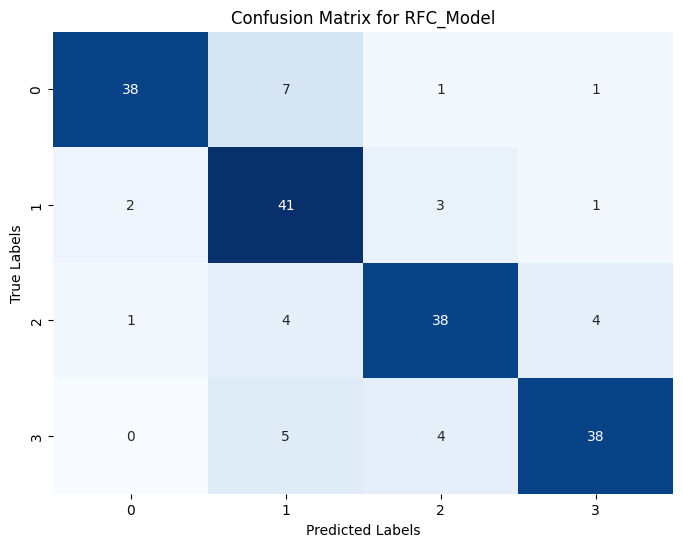

Confusion Matrix for XGBC_Model:
[[36 11  0  0]
 [ 1 42  3  1]
 [ 0  1 45  1]
 [ 1  7  4 35]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85        47
           1       0.69      0.89      0.78        47
           2       0.87      0.96      0.91        47
           3       0.95      0.74      0.83        47

    accuracy                           0.84       188
   macro avg       0.86      0.84      0.84       188
weighted avg       0.86      0.84      0.84       188



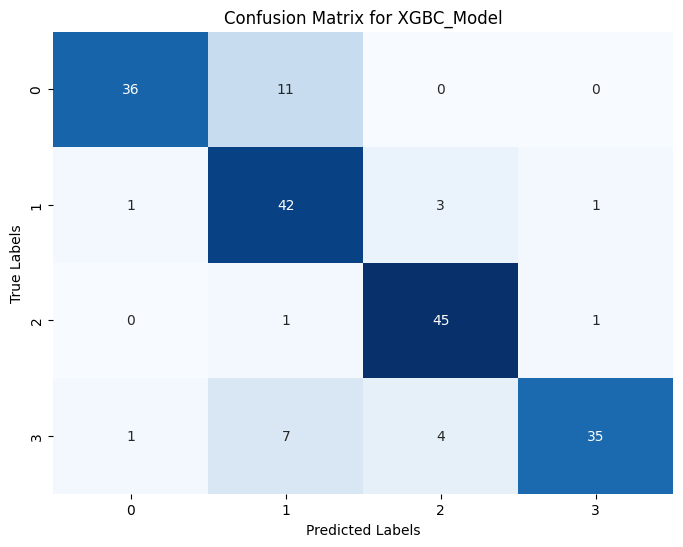

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix for MLP_Model:
[[38  8  1  0]
 [ 1 42  4  0]
 [ 4  4 37  2]
 [ 1  6  2 38]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        47
           1       0.70      0.89      0.79        47
           2       0.84      0.79      0.81        47
           3       0.95      0.81      0.87        47

    accuracy                           0.82       188
   macro avg       0.84      0.82      0.83       188
weighted avg       0.84      0.82      0.83       188



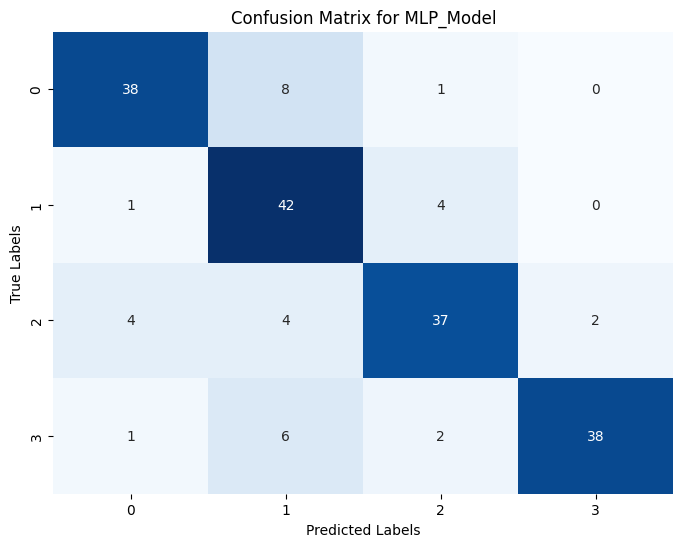

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix for CNN_Model:
[[22 23  2  0]
 [ 8 35  3  1]
 [ 5 27 11  4]
 [ 2 20  4 21]]
              precision    recall  f1-score   support

           0       0.59      0.47      0.52        47
           1       0.33      0.74      0.46        47
           2       0.55      0.23      0.33        47
           3       0.81      0.45      0.58        47

    accuracy                           0.47       188
   macro avg       0.57      0.47      0.47       188
weighted avg       0.57      0.47      0.47       188



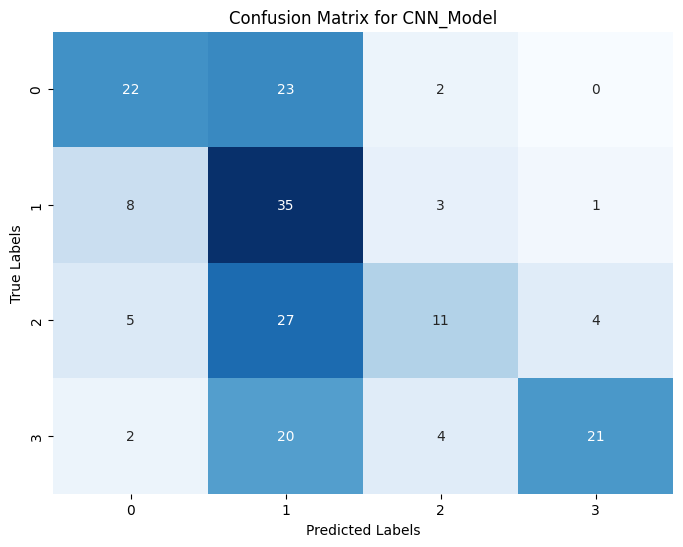

In [54]:
def print_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # Nếu y_pred là xác suất hoặc giá trị liên tục, hãy chuyển đổi thành nhãn
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:  # Kiểm tra xem y_pred có chứa xác suất không
        y_pred = np.argmax(y_pred, axis=1)  # Lấy nhãn có xác suất cao nhất

    cm = confusion_matrix(y_test, y_pred)

    print(f'Confusion Matrix for {model_name}:')
    print(cm)
    print(classification_report(y_test, y_pred))

    # Vẽ ma trận dự đoán
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# In ma trận dự đoán cho từng mô hình
print_confusion_matrix(RFC_Model, X_test, y_test, 'RFC_Model')
print_confusion_matrix(XGBC_Model, X_test, y_test, 'XGBC_Model')
print_confusion_matrix(MLP_Model, X_test, y_test, 'MLP_Model')
print_confusion_matrix(CNN_Model, X_test, y_test, 'CNN_Model')

In [55]:
# Extract feature importances
feature_importances = RFC_Model.feature_importances_
features = X_test.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Lọc các đặc trưng có độ quan trọng lớn hơn 0.01
importance_df = importance_df[importance_df['Importance'] > 0.01]
# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
fig_importances = go.Figure()

fig_importances.add_trace(go.Bar(
    x=importance_df['Feature'],
    y=importance_df['Importance'],
    marker_color='royalblue'
))

fig_importances.update_layout(
    title='Độ quan trọng của các đặc trưng từ mô hình XGBClassifier Classifier',
    xaxis_title='Feature',
    yaxis_title='Importance',
    xaxis_tickangle=-45
)

fig_importances.show()

In [56]:
def get_reverse_mapping(rename_mapping_file='model/rename_mapping.csv'):
    rename_df = pd.read_csv(rename_mapping_file)
    reverse_mapping = dict(zip(rename_df['Tên mới'], rename_df['Tên cũ']))
    return reverse_mapping

# Áp dụng mã hóa ngược
reverse_mapping = get_reverse_mapping()

# Đổi tên các đặc trưng trong DataFrame 'importance_df' theo reverse_mapping
importance_df['Feature'] = importance_df['Feature'].map(reverse_mapping)
print(importance_df)
importance_df.to_csv('data/DataFinal/model/importance_df.csv')

                                              Feature  Importance
13                       13. Nghề nghiệp của BỐ em là    0.033482
10        10. Trình độ học vấn cao nhất của MẸ em là:    0.032369
0                                Bạn đang ở tỉnh nào?    0.031177
11        11. Trình độ học vấn cao nhất của BỐ em là:    0.027785
3   5. Bạn là người dân tộc gì (Ví dụ: Kinh, Mông,...    0.023860
16  16. Hiện nay em đi học thêm bên ngoài trường m...    0.022524
4   6.  Khoảng cách từ nhà/ nơi ở của em đến trườn...    0.017919
14  14. Thu nhập trung bình mỗi tháng của gia đình...    0.017351
2                                         2. Khối lớp    0.016866
12                       12. Nghề nghiệp của MẸ em là    0.015960
18  18. Nếu em đi học thêm, mỗi tháng mất bao nhiê...    0.015958
7   8. Những phương tiện nào sau đây có trong gia ...    0.015763
46  II.  ĐỘNG CƠ, TỰ TIN, QUAN ĐIỂM VỀ HỌC TẬP MÔN...    0.014820
17  17. Nếu học thêm, mỗi tuần em học thêm bao nhi...    0.014784
22  I. GIA